In [1]:

# 基于迁移学习的两阶段方法

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
import os
import pandas as pd
from sklearn.metrics import mean_squared_error


# 导入模型和数据加载器
from AdaptiveBILSTM import AdaptiveBiLSTM, DomainDiscriminator,MultiScaleEncoder
from dataloader import create_all_dataloaders, create_category_dataloaders, create_transfer_dataloaders
from calculate import calculate_metrics, print_metrics_table,calculate_uncertainty_metrics
# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [2]:
# 模型参数设置
batch_size = 32
sequence_length = 24
forecast_horizon = 24
hidden_dim = 64
num_layers = 2
dropout = 0.2
learning_rate = 0.001
weight_decay = 1e-4
epochs = 15  # 源域预训练轮次
input_dim = 6
num_domains = 6  # 新增：域的数量

In [3]:

import torch
import numpy as np

def predict_with_uncertainty(model, inputs, category, domain_idx=None, mc_samples=100, device='cuda'):
    """
    使用MC Dropout进行不确定性估计 - 适配新的模型接口
    """
    model = model.to(device)
    inputs = inputs.to(device)
    category = category.to(device)
    model.train()  # 开启dropout以进行随机采样
    
    predictions = []
    for _ in range(mc_samples):
        # 修改: 使用新的模型接口
        outputs = model(inputs, category, domain_idx=domain_idx)  # 添加domain_idx参数
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # 如果模型返回元组，取第一个元素
        
        predictions.append(outputs.detach())
    
    # 将预测堆叠为形状[mc_samples, batch, buildings, forecasts]
    try:
        stacked_preds = torch.stack(predictions, dim=0)
        
        # 计算平均值和标准差
        mean_pred = torch.mean(stacked_preds, dim=0)
        std_pred = torch.std(stacked_preds, dim=0)
        
        # 计算95%置信区间
        lower_bound = mean_pred - 1.96 * std_pred
        upper_bound = mean_pred + 1.96 * std_pred
        
        # 确保边界在有效范围内
        lower_bound = torch.clamp(lower_bound, 0, 1)
        upper_bound = torch.clamp(upper_bound, 0, 1)
        
        # 转换为CPU NumPy数组
        return (mean_pred.cpu().numpy(),
                lower_bound.cpu().numpy(),
                upper_bound.cpu().numpy(),
                std_pred.cpu().numpy())
    
    except Exception as e:
        print(f"处理MC采样结果时出错: {str(e)}")
        # 如果堆叠或其他操作失败，使用第一个样本作为预测
        try:
            mean_pred = predictions[0].cpu().numpy()
            std_pred = np.ones_like(mean_pred) * 0.1
            lower_bound = np.maximum(mean_pred - 1.96 * std_pred, 0)
            upper_bound = np.minimum(mean_pred + 1.96 * std_pred, 1)
            return mean_pred, lower_bound, upper_bound, std_pred
        except:
            # 最后的后备方案：返回零数组
            shape = list(inputs.shape)
            if len(shape) >= 3:
                shape[-1] = 1
            zeros = np.zeros(shape)
            return zeros, zeros, zeros, zeros
def calculate_transfer_metrics(source_features, target_features, source_outputs=None, target_outputs=None, baseline_predictions=None, targets=None):
    """
    计算迁移学习的综合评估指标
    
    Args:
        source_features: 源域特征 [batch_size, feature_dim]
        target_features: 目标域特征 [batch_size, feature_dim]
        source_outputs: 源域模型输出（可选）
        target_outputs: 目标域模型输出（可选）
        baseline_predictions: 基线模型预测（可选）
        targets: 真实目标值（可选，用于计算负迁移）
    """
    import traceback  # 导入traceback以便打印详细错误信息
    
    # 处理3D特征 - 将3D特征转换为2D
    if len(source_features.shape) == 3:  # [batch, seq_len, feature_dim]
        logging.info(f"检测到3D特征，进行展平: source_features.shape={source_features.shape}")
        # 方法2：平均所有时间步
        source_features = source_features.mean(dim=1)  # [batch, feature_dim]
        target_features = target_features.mean(dim=1)  # [batch, feature_dim]
        
        logging.info(f"展平后: source_features.shape={source_features.shape}, target_features.shape={target_features.shape}")
    
    # 确保特征维度匹配
    if source_features.size(1) != target_features.size(1):
        logging.warning(f"特征维度不匹配: source_features.shape={source_features.shape}, target_features.shape={target_features.shape}")
        return {
            'a_distance': 'N/A',
            'feature_alignment': 'N/A',
            'mmd': 'N/A',
            'sample_efficiency': None
        }
    
    # 检查特征数量是否过大，可能导致内存问题
    max_samples = 5000
    if source_features.size(0) > max_samples or target_features.size(0) > max_samples:
        logging.warning(f"特征数量过大，进行采样: source_features.shape={source_features.shape}, target_features.shape={target_features.shape}")
        
        if source_features.size(0) > max_samples:
            indices = torch.randperm(source_features.size(0))[:max_samples]
            source_features = source_features[indices]
        
        if target_features.size(0) > max_samples:
            indices = torch.randperm(target_features.size(0))[:max_samples]
            target_features = target_features[indices]
        
        logging.info(f"采样后: source_features.shape={source_features.shape}, target_features.shape={target_features.shape}")
    
    def calculate_mmd(x, y):
        """计算最大平均差异(MMD)"""
        try:
            x_kernel = torch.mm(x, x.t())
            y_kernel = torch.mm(y, y.t())
            xy_kernel = torch.mm(x, y.t())
            return x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
        except Exception as e:
            logging.error(f"计算MMD时出错: {str(e)}")
            return float('nan')
    
    def calculate_a_distance(source_features, target_features):
        """计算A-distance"""
        try:
            domain_classifier = nn.Sequential(
                nn.Linear(source_features.size(1), 50),
                nn.ReLU(),
                nn.Linear(50, 1)
            ).to(source_features.device)
            
            source_domain_labels = torch.ones(source_features.size(0), 1).to(source_features.device)
            target_domain_labels = torch.zeros(target_features.size(0), 1).to(source_features.device)
            
            features = torch.cat([source_features, target_features], dim=0)
            labels = torch.cat([source_domain_labels, target_domain_labels], dim=0)
            
            optimizer = torch.optim.Adam(domain_classifier.parameters())
            criterion = nn.BCEWithLogitsLoss()
            
            for _ in range(100):
                optimizer.zero_grad()
                preds = domain_classifier(features)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                # 确保使用浮点数计算均值
                preds = torch.sigmoid(domain_classifier(features))
                predicted_labels = (preds > 0.5).float()
                error = (predicted_labels != labels).float().mean()
            
            return 2 * (1 - 2 * error)
        except Exception as e:
            logging.error(f"计算A-distance时出错: {str(e)}")
            traceback.print_exc()  # 打印详细错误信息
            return float('nan')
    
    def calculate_feature_alignment(source_features, target_features):
        """计算特征对齐质量"""
        try:
            source_norm = F.normalize(source_features, p=2, dim=1)
            target_norm = F.normalize(target_features, p=2, dim=1)
            similarity = torch.mm(source_norm, target_norm.t())
            return similarity.mean()
        except Exception as e:
            logging.error(f"计算特征对齐质量时出错: {str(e)}")
            return float('nan')
    
    def detect_negative_transfer(target_loss, baseline_loss):
        """检测负迁移"""
        # 确保输入是标量值
        if isinstance(target_loss, torch.Tensor):
            target_loss = target_loss.item()
        if isinstance(baseline_loss, torch.Tensor):
            baseline_loss = baseline_loss.item()
            
        is_negative = target_loss > baseline_loss
        transfer_gain = baseline_loss - target_loss
        
        return {
            'is_negative': bool(is_negative),  # 确保返回Python布尔值
            'transfer_gain': float(transfer_gain)  # 确保返回Python浮点数
        }
    
    def calculate_sample_efficiency(performance_curve):
        """计算样本效率"""
        target_performance = 0.9  # 可调整的目标性能阈值
        for i, perf in enumerate(performance_curve):
            if perf >= target_performance:
                return i + 1
        return len(performance_curve)

    try:
        metrics = {
            'a_distance': calculate_a_distance(source_features, target_features),
            'feature_alignment': calculate_feature_alignment(source_features, target_features),
            'mmd': calculate_mmd(source_features, target_features),
            'sample_efficiency': None  # 在训练过程中更新
        }
    except Exception as e:
        logging.error(f"计算迁移学习指标时出错: {str(e)}")
        traceback.print_exc()  # 打印详细错误信息
        return {
            'a_distance': 'N/A',
            'feature_alignment': 'N/A',
            'mmd': 'N/A',
            'sample_efficiency': None
        }
    
    
    # 如果提供了输出、基线预测和目标值，检测负迁移
    if target_outputs is not None and baseline_predictions is not None and targets is not None:
        try:
            # 确保所有输入都是张量并且形状匹配
            # 首先转换为numpy数组以便统一处理
            if isinstance(target_outputs, torch.Tensor):
                target_outputs = target_outputs.detach().cpu().numpy()
            if isinstance(baseline_predictions, torch.Tensor):
                baseline_predictions = baseline_predictions.detach().cpu().numpy()
            if isinstance(targets, torch.Tensor):
                targets = targets.detach().cpu().numpy()
            
            # 确保都是一维数组
            target_outputs = np.array(target_outputs).flatten()
            baseline_predictions = np.array(baseline_predictions).flatten()
            targets = np.array(targets).flatten()
            
            # 确保所有数组长度相同
            min_length = min(len(target_outputs), len(baseline_predictions), len(targets))
            target_outputs = target_outputs[:min_length]
            baseline_predictions = baseline_predictions[:min_length]
            targets = targets[:min_length]
            
            # 计算MSE损失
            target_loss = np.mean((target_outputs - targets) ** 2)
            baseline_loss = np.mean((baseline_predictions - targets) ** 2)
            
            # 打印调试信息
            logging.debug(f"target_loss: {target_loss}, type: {type(target_loss)}")
            logging.debug(f"baseline_loss: {baseline_loss}, type: {type(baseline_loss)}")
            
            # 检测负迁移
            neg_transfer = detect_negative_transfer(target_loss, baseline_loss)
            metrics['is_negative_transfer'] = neg_transfer['is_negative']
            metrics['transfer_gain'] = neg_transfer['transfer_gain']
            
        except Exception as e:
            logging.error(f"计算负迁移指标时出错: {str(e)}")
            traceback.print_exc()  # 打印详细错误信息
            metrics['is_negative_transfer'] = 'N/A'
            metrics['transfer_gain'] = 'N/A'
    
    return metrics


In [4]:
def evaluate_model(model, test_loader, model_name="Model", baseline_model=None, device='cuda', domain_idx=None):
    """
    评估模型在测试集上的性能，并支持基线模型的完整指标计算
    """
    # 定义内部函数，确保在使用前声明
    def calculate_improved_mape(y_true, y_pred, epsilon=0.01):
        """计算改进的MAPE，忽略接近零的值"""
        mask = np.abs(y_true) > epsilon
        if not np.any(mask):
            return float('nan')
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    model.eval()
    all_predictions = []
    all_targets = []
    all_lower_bounds = []
    all_upper_bounds = []
    all_uncertainties = []
    source_features = []
    target_features = []
    source_outputs = []
    target_outputs = []
    
    # 新增：基线模型的特征和输出收集
    baseline_source_features = []
    baseline_target_features = []
    baseline_source_outputs = []
    baseline_target_outputs = []
    
    # 新增：基线模型不确定性存储
    all_baseline_lower_bounds = []
    all_baseline_upper_bounds = []
    all_baseline_uncertainties = []
    
    with torch.no_grad():
        for inputs, targets, _, category_onehot in test_loader:
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            category_onehot = category_onehot.float().to(device)
            
            # 处理迁移模型的特征和输出
            try:
                if hasattr(model, 'time_series_encoder'):
                    try:
                        source_feat = model.time_series_encoder(inputs, domain_idx=0)
                        source_features.append(source_feat.mean(dim=1))
                        target_feat = model.time_series_encoder(inputs, domain_idx=1)
                        target_features.append(target_feat.mean(dim=1))
                    except Exception as e:
                        print(f"提取域特征时出错: {str(e)}")
                
                mean_pred, lower_bound, upper_bound, uncertainty = predict_with_uncertainty(
                    model=model, inputs=inputs, category=category_onehot, 
                    domain_idx=domain_idx, device=device, mc_samples=50
                )
                
                if isinstance(mean_pred, torch.Tensor):
                    mean_pred = mean_pred.cpu().numpy()
                
                try:
                    if hasattr(model, 'time_series_encoder'):
                        source_outputs.append(mean_pred)
                        target_pred = model(inputs, category_onehot, domain_idx=domain_idx)
                        if isinstance(target_pred, torch.Tensor):
                            target_pred = target_pred.cpu().numpy()
                        target_outputs.append(target_pred)
                except Exception as e:
                    print(f"收集域输出时出错: {str(e)}")
                
                all_predictions.append(mean_pred)
                all_targets.append(targets.cpu().numpy())
                all_lower_bounds.append(lower_bound)
                all_upper_bounds.append(upper_bound)
                all_uncertainties.append(uncertainty)
            except Exception as e:
                print(f"批次处理错误: {str(e)}")
                continue
            
            # 新增：处理基线模型的特征和输出
            if baseline_model is not None:
                try:
                    if hasattr(baseline_model, 'time_series_encoder'):
                        try:
                            baseline_source_feat = baseline_model.time_series_encoder(inputs, domain_idx=0)
                            baseline_source_features.append(baseline_source_feat.mean(dim=1))
                            baseline_target_feat = baseline_model.time_series_encoder(inputs, domain_idx=1)
                            baseline_target_features.append(baseline_target_feat.mean(dim=1))
                        except Exception as e:
                            print(f"提取基线域特征时出错: {str(e)}")
                    
                    if hasattr(baseline_model, 'predict'):
                        baseline_pred = baseline_model.predict(inputs)
                    else:
                        baseline_pred = baseline_model(inputs, category_onehot)
                        if isinstance(baseline_pred, tuple):
                            baseline_pred = baseline_pred[0]
                    
                    if isinstance(baseline_pred, torch.Tensor):
                        baseline_pred = baseline_pred.cpu().numpy()
                    
                    baseline_source_outputs.append(baseline_pred)
                    baseline_target_outputs.append(baseline_pred)  # 基线模型没有域适应能力
                    
                    # 新增：处理基线模型不确定性
                    try:
                        if hasattr(baseline_model, 'predict_with_uncertainty'):
                            # 调用基线模型的不确定性预测方法
                            bl_mean, bl_lower, bl_upper, bl_uncertainty = predict_with_uncertainty(
                                model=baseline_model, inputs=inputs, category=category_onehot,
                                domain_idx=domain_idx, device=device, mc_samples=50
                            )
                            all_baseline_lower_bounds.append(bl_lower)
                            all_baseline_upper_bounds.append(bl_upper)
                            all_baseline_uncertainties.append(bl_uncertainty)
                        else:
                            # 无不确定性方法时生成默认边界
                            bl_pred = baseline_pred.reshape(-1, 1)
                            all_baseline_lower_bounds.append(bl_pred * 0.9)
                            all_baseline_upper_bounds.append(bl_pred * 1.1)
                            all_baseline_uncertainties.append(np.ones_like(bl_pred) * 0.1)
                    except Exception as e:
                        print(f"基线不确定性计算错误: {e}")
                        # 生成默认不确定性
                        bl_pred = baseline_pred.reshape(-1, 1)
                        all_baseline_lower_bounds.append(bl_pred * 0.9)
                        all_baseline_upper_bounds.append(bl_pred * 1.1)
                        all_baseline_uncertainties.append(np.ones_like(bl_pred) * 0.1)
                        
                except Exception as e:
                    print(f"处理基线模型时出错: {str(e)}")
    
    if not all_predictions:
        print("警告: 无有效预测，无法评估")
        return {"Model": model_name, "Error": "无有效预测"}
    
    try:
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
    except Exception as e:
        print(f"合并数据错误: {str(e)}")
        return {"Model": model_name, "Error": f"合并失败: {str(e)}"}
    
    if not all_lower_bounds or not all_upper_bounds or not all_uncertainties:
        print("警告: 使用默认不确定性估计")
        all_lower_bounds = all_predictions * 0.9
        all_upper_bounds = all_predictions * 1.1
        all_uncertainties = np.ones_like(all_predictions) * 0.1
    else:
        try:
            all_lower_bounds = np.concatenate(all_lower_bounds, axis=0)
            all_upper_bounds = np.concatenate(all_upper_bounds, axis=0)
            all_uncertainties = np.concatenate(all_uncertainties, axis=0)
        except Exception as e:
            print(f"合并不确定性错误: {str(e)}")
            all_lower_bounds = all_predictions * 0.9
            all_upper_bounds = all_predictions * 1.1
            all_uncertainties = np.ones_like(all_predictions) * 0.1
    
    all_predictions_flat = all_predictions.reshape(-1)
    all_targets_flat = all_targets.reshape(-1)
    
    if all_lower_bounds.size != all_predictions_flat.size:
        print(f"形状不匹配: 下界{all_lower_bounds.shape} vs 预测{all_predictions.shape}")
        all_lower_bounds = all_lower_bounds.reshape(-1)[:all_predictions_flat.size]
        all_upper_bounds = all_upper_bounds.reshape(-1)[:all_predictions_flat.size]
        all_uncertainties = all_uncertainties.reshape(-1)[:all_predictions_flat.size]
    else:
        all_lower_bounds = all_lower_bounds.reshape(-1)
        all_upper_bounds = all_upper_bounds.reshape(-1)
        all_uncertainties = all_uncertainties.reshape(-1)
    
    print("\n数据形状:")
    print(f"预测: {all_predictions_flat.shape}, 目标: {all_targets_flat.shape}")
    print(f"下界: {all_lower_bounds.shape}, 上界: {all_upper_bounds.shape}")
    
    baseline_predictions = None
    baseline_metrics = {}
    if baseline_model is not None:
        baseline_model.eval()
        all_baseline_predictions = []
        with torch.no_grad():
            for inputs, _, _, category_onehot in test_loader:
                try:
                    inputs = inputs.float().to(device)
                    category_onehot = category_onehot.float().to(device)
                    if hasattr(baseline_model, 'predict'):
                        baseline_pred = baseline_model.predict(inputs)
                    else:
                        baseline_pred = baseline_model(inputs, category_onehot)
                        if isinstance(baseline_pred, tuple):
                            baseline_pred = baseline_pred[0]
                    if isinstance(baseline_pred, torch.Tensor):
                        baseline_pred = baseline_pred.cpu().numpy()
                    all_baseline_predictions.append(baseline_pred)
                except Exception as e:
                    print(f"基线预测错误: {str(e)}")
        
        if all_baseline_predictions:
            try:
                baseline_predictions = np.concatenate(all_baseline_predictions, axis=0).reshape(-1)
                if baseline_predictions.size != all_predictions_flat.size:
                    print(f"基线形状不匹配: {baseline_predictions.shape} vs {all_predictions_flat.shape}")
                    baseline_predictions = baseline_predictions[:all_predictions_flat.size]
                
                # 合并不确定性数据
                if all_baseline_lower_bounds:
                    try:
                        all_baseline_lower_bounds = np.concatenate(all_baseline_lower_bounds, axis=0).reshape(-1)
                        all_baseline_upper_bounds = np.concatenate(all_baseline_upper_bounds, axis=0).reshape(-1)
                        all_baseline_uncertainties = np.concatenate(all_baseline_uncertainties, axis=0).reshape(-1)
                        
                        # 确保形状匹配
                        if all_baseline_lower_bounds.size != baseline_predictions.size:
                            all_baseline_lower_bounds = all_baseline_lower_bounds[:baseline_predictions.size]
                            all_baseline_upper_bounds = all_baseline_upper_bounds[:baseline_predictions.size]
                            all_baseline_uncertainties = all_baseline_uncertainties[:baseline_predictions.size]
                    except Exception as e:
                        print(f"合并不确定性错误: {e}")
                        # fallback到默认值
                        all_baseline_lower_bounds = baseline_predictions * 0.9
                        all_baseline_upper_bounds = baseline_predictions * 1.1
                        all_baseline_uncertainties = np.ones_like(baseline_predictions) * 0.1
                else:
                    # 无收集数据时使用默认值
                    all_baseline_lower_bounds = baseline_predictions * 0.9
                    all_baseline_upper_bounds = baseline_predictions * 1.1
                    all_baseline_uncertainties = np.ones_like(baseline_predictions) * 0.1
                
                # 计算基线模型指标（包含不确定性）
                baseline_metrics = calculate_metrics(
                    predictions=baseline_predictions,
                    real_values=all_targets_flat,
                    model_name=f"Baseline for {model_name}",
                    baseline_predictions=None,  # 基线无需自身基线
                    lower_bounds=all_baseline_lower_bounds,
                    upper_bounds=all_baseline_upper_bounds,
                    confidence=0.95
                )
                # 补充基线模型的MAPE计算（使用改进版）
                baseline_metrics['MAPE'] = calculate_improved_mape(all_targets_flat, baseline_predictions, epsilon=0.01)
                baseline_metrics['avg_uncertainty'] = np.mean(all_baseline_uncertainties)
            except Exception as e:
                print(f"处理基线错误: {str(e)}")
                baseline_predictions = None
    
    try:
        metrics = calculate_metrics(
            predictions=all_predictions_flat,
            real_values=all_targets_flat,
            model_name=model_name,
            baseline_predictions=baseline_predictions,
            lower_bounds=all_lower_bounds,
            upper_bounds=all_upper_bounds,
            confidence=0.95
        )
        
        metrics['avg_uncertainty'] = np.mean(all_uncertainties)
        
        try:
            metrics['MAPE'] = calculate_improved_mape(all_targets_flat, all_predictions_flat, epsilon=0.01)
        except Exception as e:
            print(f"MAPE计算错误: {str(e)}")
            if 'MAPE' not in metrics:
                metrics['MAPE'] = float('nan')
    
        # 迁移学习指标计算
        if source_features and target_features and source_outputs and target_outputs:
            try:
                # 计算迁移模型的迁移指标
                source_features_tensor = torch.cat(source_features, dim=0).cpu()
                target_features_tensor = torch.cat(target_features, dim=0).cpu()
                source_outputs = np.concatenate(source_outputs, axis=0)
                target_outputs = np.concatenate(target_outputs, axis=0)
                
                transfer_metrics = calculate_transfer_metrics(
                    source_features=source_features_tensor,
                    target_features=target_features_tensor,
                    source_outputs=source_outputs,
                    target_outputs=target_outputs,
                    baseline_predictions=baseline_predictions,
                    targets=all_targets_flat
                )
                metrics.update(transfer_metrics)
                
                # 计算基线模型的迁移指标
                if baseline_source_features and baseline_target_features and baseline_source_outputs and baseline_target_outputs:
                    try:
                        baseline_source_features_tensor = torch.cat(baseline_source_features, dim=0).cpu()
                        baseline_target_features_tensor = torch.cat(baseline_target_features, dim=0).cpu()
                        baseline_source_outputs = np.concatenate(baseline_source_outputs, axis=0)
                        baseline_target_outputs = np.concatenate(baseline_target_outputs, axis=0)
                        
                        baseline_transfer_metrics = calculate_transfer_metrics(
                            source_features=baseline_source_features_tensor,
                            target_features=baseline_target_features_tensor,
                            source_outputs=baseline_source_outputs,
                            target_outputs=baseline_target_outputs,
                            baseline_predictions=baseline_predictions,
                            targets=all_targets_flat
                        )
                        
                        baseline_transfer_metrics = {f"baseline_{k}": v for k, v in baseline_transfer_metrics.items()}
                        metrics.update(baseline_transfer_metrics)
                        
                        # 计算改进率
                        if 'a_distance' in transfer_metrics and 'baseline_a_distance' in metrics:
                            metrics['a_distance_improvement'] = metrics['baseline_a_distance'] - metrics['a_distance']
                        if 'mmd' in transfer_metrics and 'baseline_mmd' in metrics:
                            metrics['mmd_improvement'] = metrics['baseline_mmd'] - metrics['mmd']
                        if 'feature_alignment' in transfer_metrics and 'baseline_feature_alignment' in metrics:
                            metrics['alignment_improvement'] = metrics['feature_alignment'] - metrics['baseline_feature_alignment']
                    
                    except Exception as e:
                        print(f"计算基线迁移指标时出错: {str(e)}")
                else:
                    print("警告: 基线模型的迁移学习数据缺失，跳过相关指标")
            except Exception as e:
                print(f"迁移指标错误: {str(e)}")
        else:
            print("警告: 迁移学习数据缺失，跳过相关指标")
    
    except Exception as e:
        print(f"指标计算错误: {str(e)}")
        rmse = np.sqrt(mean_squared_error(all_targets_flat, all_predictions_flat))
        r2 = r2_score(all_targets_flat, all_predictions_flat) if all_predictions_flat.size > 0 and all_targets_flat.size > 0 else np.nan
        metrics = {
            'Model': model_name,
            'RMSD': rmse,
            'R2': r2,
            'avg_uncertainty': np.mean(all_uncertainties)
        }
        try:
            metrics['MAPE'] = calculate_improved_mape(all_targets_flat, all_predictions_flat, epsilon=0.01)
        except:
            metrics['MAPE'] = float('nan')
    
    print(f"\n{model_name} 评估报告:")
    print(f"RMSD: {metrics.get('RMSD', 'N/A'):.4f}")
    print(f"MAPE: {metrics.get('MAPE', 'N/A'):.2f}%")
    print(f"R²: {metrics.get('R2', 'N/A'):.4f}")
    print(f"CV-RMSE: {metrics.get('CV-RMSE', 'N/A'):.4f}%")
    print(f"SD_real: {metrics.get('SD_real', 'N/A'):.4f}")
    print(f"SD_pred: {metrics.get('SD_pred', 'N/A'):.4f}")
    print(f"CC: {metrics.get('CC', 'N/A'):.4f}")
    
    if 'PIR' in metrics and metrics['PIR'] is not None:
        pir = metrics.get('PIR', 'N/A')
        if isinstance(pir, (int, float)):
            print(f"RMSD改进率(PIR): {pir:.2f}%")
    
    if baseline_metrics:
        print(f"\n{'Baseline Model' + ' ' * (len(model_name) - 11)} 评估报告:")
        print(f"RMSD: {baseline_metrics.get('RMSD', 'N/A'):.4f}")
        print(f"MAPE: {baseline_metrics.get('MAPE', 'N/A'):.2f}%")
        print(f"R²: {baseline_metrics.get('R2', 'N/A'):.4f}")
        print(f"CV-RMSE: {baseline_metrics.get('CV-RMSE', 'N/A'):.4f}%")
        print(f"SD_real: {baseline_metrics.get('SD_real', 'N/A'):.4f}")
        print(f"SD_pred: {baseline_metrics.get('SD_pred', 'N/A'):.4f}")
        print(f"CC: {baseline_metrics.get('CC', 'N/A'):.4f}")
        
        # 安全打印不确定性指标（避免字符串格式化错误）
        if 'PICP' in baseline_metrics:
            print("\n基线模型不确定性评估:")
            picp = baseline_metrics.get('PICP', 'N/A')
            print(f"PICP: {picp:.2f}%" if isinstance(picp, (int, float)) else f"PICP: {picp}")
            
            nmpiw = baseline_metrics.get('NMPIW', 'N/A')
            print(f"NMPIW: {nmpiw:.4f}" if isinstance(nmpiw, (int, float)) else f"NMPIW: {nmpiw}")
            
            cal_err = baseline_metrics.get('calibration_error', 'N/A')
            print(f"校准误差: {cal_err:.2f}%" if isinstance(cal_err, (int, float)) else f"校准误差: {cal_err}")
            
            uncertainty = baseline_metrics.get('avg_uncertainty', 'N/A')
            print(f"平均不确定性: {uncertainty:.4f}" if isinstance(uncertainty, (int, float)) else f"平均不确定性: {uncertainty}")
    
    # 打印迁移学习评估对比
    if any(key in metrics for key in ['a_distance', 'feature_alignment', 'mmd']):
        print("\n迁移学习评估:")
        print(f"A-distance: {metrics.get('a_distance', 'N/A'):.4f}")
        print(f"特征对齐: {metrics.get('feature_alignment', 'N/A'):.4f}")
        print(f"MMD: {metrics.get('mmd', 'N/A'):.4f}")
        
        if any(key in metrics for key in ['baseline_a_distance', 'baseline_feature_alignment', 'baseline_mmd']):
            print("\n基线模型迁移学习评估:")
            print(f"A-distance: {metrics.get('baseline_a_distance', 'N/A'):.4f}")
            print(f"特征对齐: {metrics.get('baseline_feature_alignment', 'N/A'):.4f}")
            print(f"MMD: {metrics.get('baseline_mmd', 'N/A'):.4f}")
            
            if 'a_distance_improvement' in metrics:
                print(f"\nA-distance改进: {metrics.get('a_distance_improvement', 'N/A'):.4f}")
            if 'mmd_improvement' in metrics:
                print(f"MMD改进: {metrics.get('mmd_improvement', 'N/A'):.4f}")
            if 'alignment_improvement' in metrics:
                print(f"特征对齐改进: {metrics.get('alignment_improvement', 'N/A'):.4f}")
    
    if 'PICP' in metrics:
        print("\n不确定性评估:")
        picp = metrics.get('PICP', 'N/A')
        print(f"PICP: {picp:.2f}%" if isinstance(picp, (int, float)) else f"PICP: {picp}")
        
        nmpiw = metrics.get('NMPIW', 'N/A')
        print(f"NMPIW: {nmpiw:.4f}" if isinstance(nmpiw, (int, float)) else f"NMPIW: {nmpiw}")
        
        cal_err = metrics.get('calibration_error', 'N/A')
        print(f"校准误差: {cal_err:.2f}%" if isinstance(cal_err, (int, float)) else f"校准误差: {cal_err}")
        
        uqs = metrics.get('UQS', 'N/A')
        print(f"UQS: {uqs:.4f}" if isinstance(uqs, (int, float)) else f"UQS: {uqs}")
        
        uncertainty = metrics.get('avg_uncertainty', 'N/A')
        print(f"平均不确定性: {uncertainty:.4f}" if isinstance(uncertainty, (int, float)) else f"平均不确定性: {uncertainty}")
    
    try:
        sample_idx = 0
        if len(all_predictions.shape) == 3 and all_predictions.shape[0] > 0 and all_predictions.shape[1] > 0 and all_predictions.shape[2] > 0:
            max_horizon = min(10, all_predictions.shape[2])
            plt.figure(figsize=(10, 6))
            try:
                plt.fill_between(
                    range(max_horizon),
                    all_lower_bounds.reshape(all_predictions.shape)[sample_idx, 0, :max_horizon],
                    all_upper_bounds.reshape(all_predictions.shape)[sample_idx, 0, :max_horizon],
                    alpha=0.3, color='blue', label='95% Confidence Interval'
                )
                plt.plot(range(max_horizon), all_predictions[sample_idx, 0, :max_horizon], 'b-o', label='Predictions')
                plt.plot(range(max_horizon), all_targets[sample_idx, 0, :max_horizon], 'r-x', label='Ground Truth')
            except Exception as e:
                print(f"3D data visualization error: {str(e)}")
                plt.plot(range(max_horizon), all_predictions[sample_idx, 0, :max_horizon], 'b-o', label='Predictions')
                plt.plot(range(max_horizon), all_targets[sample_idx, 0, :max_horizon], 'r-x', label='Ground Truth')
        
        elif len(all_predictions.shape) == 2 and all_predictions.shape[0] > 0 and all_predictions.shape[1] > 0:
            max_horizon = min(10, all_predictions.shape[1])
            plt.figure(figsize=(10, 6))
            try:
                plt.fill_between(
                    range(max_horizon),
                    all_lower_bounds.reshape(all_predictions.shape)[sample_idx, :max_horizon],
                    all_upper_bounds.reshape(all_predictions.shape)[sample_idx, :max_horizon],
                    alpha=0.3, color='blue', label='95% Confidence Interval'
                )
                plt.plot(range(max_horizon), all_predictions[sample_idx, :max_horizon], 'b-o', label='Predictions')
                plt.plot(range(max_horizon), all_targets[sample_idx, :max_horizon], 'r-x', label='Ground Truth')
            except Exception as e:
                print(f"2D data visualization error: {str(e)}")
                plt.plot(range(max_horizon), all_predictions[sample_idx, :max_horizon], 'b-o', label='Predictions')
                plt.plot(range(max_horizon), all_targets[sample_idx, :max_horizon], 'r-x', label='Ground Truth')
        
        elif len(all_predictions.shape) == 1 and all_predictions.shape[0] > 0:
            max_points = min(10, all_predictions.shape[0])
            plt.figure(figsize=(10, 6))
            try:
                plt.fill_between(
                    range(max_points),
                    all_lower_bounds[:max_points],
                    all_upper_bounds[:max_points],
                    alpha=0.3, color='blue', label='95% Confidence Interval'
                )
                plt.plot(range(max_points), all_predictions[:max_points], 'b-o', label='Predictions')
                plt.plot(range(max_points), all_targets[:max_points], 'r-x', label='Ground Truth')
            except Exception as e:
                print(f"1D data visualization error: {str(e)}")
                plt.plot(range(max_points), all_predictions[:max_points], 'b-o', label='Predictions')
                plt.plot(range(max_points), all_targets[:max_points], 'r-x', label='Ground Truth')
        
        else:
            print(f"Cannot visualize predictions: incompatible shape {all_predictions.shape}")
            return metrics
        
        plt.title(f'{model_name} Prediction Example\nPICP: {metrics.get("PICP", "N/A")}%')
        plt.xlabel('Prediction Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        safe_model_name = ''.join(c if c.isalnum() or c in ['-', '_'] else '_' for c in model_name)
        plt.savefig(f'prediction_sample_{safe_model_name}.png')
        plt.close()
    except Exception as e:
        print(f"可视化错误: {str(e)}")
        print(f"数据形状: 预测={all_predictions.shape}, 目标={all_targets.shape}")
    
    if baseline_metrics:
        metrics['baseline_metrics'] = baseline_metrics
    
    return metrics

## 使用全部类别进行源域模型训练

In [5]:
from bilstm import BaselineBiLSTM
import os
import json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import logging
from tqdm.auto import tqdm
import warnings
import copy
from torch import optim

# 配置日志：同时输出到文件和控制台，记录时间、等级和消息
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),  # 日志文件
        logging.StreamHandler()               # 控制台输出
    ]
)

# 忽略警告
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)



# 定义Huber损失函数
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
    
    def forward(self, predictions, targets):
        # 计算预测值与目标值之间的差异
        diff = predictions - targets
        abs_diff = torch.abs(diff)
        
        # 应用Huber损失公式
        loss = torch.where(
            abs_diff <= self.delta,
            0.5 * diff * diff,
            self.delta * (abs_diff - 0.5 * self.delta)
        )
        
        return torch.mean(loss)

# 计算损失的辅助函数
def calculate_loss(predictions, targets):
    """
    计算Huber损失
    
    参数:
    - predictions: 预测值
    - targets: 真实值
    
    返回:
    - loss: Huber损失值
    """
    # 可以直接使用PyTorch的内置HuberLoss (如果PyTorch版本≥1.9)
    # 或者使用自定义实现
    loss_fn = HuberLoss(delta=1.0)
    return loss_fn(predictions, targets)

#HuberLoss 类实现了 Huber 损失函数，它在误差较小时使用平方损失，误差较大时使用线性损失，能够减少异常值对损失的影响。calculate_loss 函数调用 HuberLoss 类计算损失。

def train_and_save_model(model, train_loader, val_loader, epochs, lr, weight_decay, 
                       model_name, save_dir='models', device='cuda', early_stopping_patience=5,
                       source_domain_idx=0, target_domain_idx=None):
    """
    训练模型并保存最佳模型，支持域自适应
    
    新增参数:
    - source_domain_idx: 源域索引，默认为0
    - target_domain_idx: 用于验证，默认为0，使用源域验证
    """
    os.makedirs(save_dir, exist_ok=True)
    model = model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 初始化记录器
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    # 保存模型配置信息（不同模型有不同的属性）
    model_config = {}
    
    # 尝试获取常见模型属性（如果存在的话）
    for attr in ['input_dim', 'hidden_dim', 'forecast_horizon', 'num_buildings', 'num_layers', 'dropout']:
        if hasattr(model, attr):
            model_config[attr] = getattr(model, attr)
    
    # 根据模型类型获取特定属性
    is_adaptive_model = hasattr(model, 'time_series_encoder')
    if is_adaptive_model:
        model_config['model_type'] = 'AdaptiveBiLSTM'
        if hasattr(model.time_series_encoder, 'num_domains'):
            model_config['num_domains'] = model.time_series_encoder.num_domains
        model_config['source_domain_idx'] = source_domain_idx
        model_config['target_domain_idx'] = target_domain_idx

    
    # 保存最佳模型的信息
    best_model_info = {
        'state_dict': None,
        'optimizer_state': None,
        'epoch': 0,
        'train_loss': float('inf'),
        'val_loss': float('inf'),
        'metrics': None
    }

    print(f"开始训练 {model_name}...")

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_train_loss = 0
        train_steps = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Training]')
        for batch in progress_bar:
            inputs, targets, category, category_onehot = [
                x.float().to(device) if torch.is_tensor(x) else x for x in batch
            ]
            
            optimizer.zero_grad()
            
            predictions = model(inputs, category_onehot, domain_idx=source_domain_idx)
                
            loss = calculate_loss(predictions, targets)  # 使用Huber损失函数
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
            train_steps += 1
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
        
        avg_train_loss = epoch_train_loss / train_steps
        train_losses.append(avg_train_loss)
        
        # 验证阶段
        model.eval()
        epoch_val_loss = 0
        val_steps = 0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Validation]')
            for batch in progress_bar:
                inputs, targets, category, category_onehot = [
                    x.float().to(device) if torch.is_tensor(x) else x for x in batch
                ]
                    # 自适应模型验证也使用源域
                predictions = model(inputs, category_onehot, domain_idx=source_domain_idx)

                    
                loss = calculate_loss(predictions, targets)
                
                epoch_val_loss += loss.item()
                val_steps += 1
                progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})
        
        avg_val_loss = epoch_val_loss / val_steps
        val_losses.append(avg_val_loss)
        
        # 学习率调整
        scheduler.step(avg_val_loss)
        
        # 计算当前模型的评估指标
        # 使用修改后的simple_evaluate_model，支持域自适应
        current_metrics = simple_evaluate_model(
            model, val_loader, f"{model_name}_epoch_{epoch+1}", 
            device=device, domain_idx=target_domain_idx if is_adaptive_model else None
        )
        
        # 检查是否是最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0
            
            # 更新最佳模型信息
            best_model_info = {
                'state_dict': copy.deepcopy(model.state_dict()),
                'optimizer_state': copy.deepcopy(optimizer.state_dict()),
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'metrics': current_metrics,
                'hyperparameters': {
                    'lr': lr,
                    'weight_decay': weight_decay,
                    'epochs': epochs,
                    'best_epoch': epoch + 1,
                    'model_config': model_config,
                    'model_type': type(model).__name__,
                    'source_domain_idx': source_domain_idx if is_adaptive_model else None,
                    'target_domain_idx': target_domain_idx if is_adaptive_model else None
                }
            }
            
            # 保存最佳模型检查点
            checkpoint_path = os.path.join(save_dir, f'{model_name}_best.pth')
            torch.save(best_model_info, checkpoint_path)
            print(f"✅ 保存最佳模型 (epoch {epoch+1}), 验证损失: {avg_val_loss:.4f}")
        else:
            patience_counter += 1
        
        # 打印当前epoch的训练信息
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"RMSD: {current_metrics['RMSD']:.4f}, "
            f"R²: {current_metrics['R2']:.4f}, "
            f"Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch+1}), "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )
        
        # 早停检查
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
    
    
    # 训练结束后，保存训练历史
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch + 1,
        'best_val_loss': best_val_loss
    }
    
    # 保存训练历史
    history_path = os.path.join(save_dir, f'{model_name}_training_history.json')
    with open(history_path, 'w') as f:
        # 将列表转换为可序列化格式
        serializable_history = {
            'train_losses': [float(loss) for loss in train_losses],
            'val_losses': [float(loss) for loss in val_losses],
            'best_epoch': best_epoch + 1,
            'best_val_loss': float(best_val_loss)
        }
        json.dump(serializable_history, f, indent=4)
    
    # 绘制训练曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_curve.png'))
    plt.close()
    
    # 恢复最佳模型状态
    model.load_state_dict(best_model_info['state_dict'])
    
    return model, best_model_info, history

# 修改简化评估函数，支持域自适应
def simple_evaluate_model(model, test_loader, model_name="Model", device='cuda', domain_idx=None):
    """
    训练中使用的简化评估函数，支持域自适应
    
    参数:
    - model: 要评估的模型
    - test_loader: 测试数据加载器
    - model_name: 模型名称
    - device: 计算设备
    - domain_idx: 域索引(None表示使用混合域)
    
    返回:
    - 简化的评估指标字典
    """
    from sklearn.metrics import mean_squared_error, r2_score
    
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets, _, category_onehot in test_loader:
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            category_onehot = category_onehot.float().to(device)
            predictions = model(inputs, category_onehot, domain_idx=0)

            
            # 收集预测和目标值
            pred_values = predictions.cpu().numpy()
            target_values = targets.cpu().numpy()
            
            all_preds.append(pred_values)
            all_targets.append(target_values)
    
    # 后续代码保持不变...
    # 合并所有批次的预测和目标
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # 展平数组以便计算指标
    all_preds = all_preds.reshape(-1)
    all_targets = all_targets.reshape(-1)
    
    # 计算基本指标
    mse = mean_squared_error(all_targets, all_preds)
    rmsd = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    
    # 计算MAPE（排除零值）
    mask = np.abs(all_targets) > 1e-6
    mape = np.mean(np.abs((all_targets[mask] - all_preds[mask]) / all_targets[mask])) * 100 if np.any(mask) else np.nan
    
    # 计算CC (相关系数)
    cc = np.corrcoef(all_preds, all_targets)[0, 1]
    
    return {
        "Model": model_name,
        "RMSD": rmsd,
        "R2": r2,
        "MAPE": mape,
        "CC": cc
    }

# 创建保存目录
os.makedirs('models', exist_ok=True)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 加载数据
print("加载所有类别的训练数据...")
train_loader, test_loader, categories = create_all_dataloaders(
    batch_size=batch_size, 
    sequence_length=sequence_length, 
    forecast_horizon=forecast_horizon
)
from torch.utils.data import Subset, DataLoader, random_split

# 从train_loader中获取完整训练建筑数据集
all_train_dataset = train_loader.dataset  # 这是ConcatDataset

# 设定划分比例（如80%训练，20%验证）
train_ratio = 0.8
val_ratio = 0.2
total_len = len(all_train_dataset)
train_len = int(total_len * train_ratio)
val_len = total_len - train_len

# 使用random_split划分
train_subset, val_subset = random_split(all_train_dataset, [train_len, val_len])

# 构建新的dataloader
batch_size = train_loader.batch_size
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# 获取数据维度信息
for inputs, targets, category, category_onehot in train_loader:
    print(f"输入形状: {inputs.shape}, 目标形状: {targets.shape}, 类别形状: {category_onehot.shape}")
    input_dim = inputs.shape[-1]
    num_buildings = inputs.shape[1]
    category_dim = category_onehot.shape[-1]
    break

# 创建域自适应模型（替换ChronosBiLSTM）
print("创建和训练AdaptiveBiLSTM模型...")
num_domains = 6  # 设置为6：1源域和5目标域
source_domain_idx = 0  # 源域索引
target_domain_idx = 0  # 评估时使用的仍然是源域

# 创建AdaptiveBiLSTM模型
source_model = AdaptiveBiLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    category_dim=category_dim,
    forecast_horizon=forecast_horizon,
    num_buildings=num_buildings,
    num_domains=num_domains,  # 新增参数，指定域数量
    num_layers=num_layers,
    dropout=dropout
)

# 训练源域模型，使用修改后的训练函数
trained_source_model, source_best_info, source_history = train_and_save_model(
    model=source_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=learning_rate,
    weight_decay=weight_decay,
    model_name='adaptive_source_huber',  # 修改模型名称
    save_dir='models',
    device=device,
    source_domain_idx=source_domain_idx,  # 指定源域索引
    target_domain_idx=target_domain_idx   # 指定目标域索引
)

# 使用改进的完整评估函数对最终模型进行评估
print("\n评估源域模型性能...")
source_metrics = evaluate_model(
    model=trained_source_model, 
    test_loader=val_loader,
    model_name="Adaptive_Source_Huber_Model",  # 修改模型名称
    device=device,
    domain_idx=source_domain_idx  # 评估时使用源域
)




# 提取重要的评估指标
print("\n源域模型评估指标:")
print(f"MAPE(%): {source_metrics['MAPE']:.2f}")
print(f"RMSD: {source_metrics['RMSD']:.4f}")
print(f"R²: {source_metrics['R2']:.4f}")

def convert_to_serializable(obj):
    """将对象转换为JSON可序列化的格式"""
    if isinstance(obj, torch.Tensor):
        # 将张量转换为Python原生类型
        obj = obj.detach().cpu().numpy()
        if obj.size == 1:
            return float(obj.item())  # 单个值转为float
        return obj.tolist()  # 数组转为列表
    elif isinstance(obj, np.ndarray):
        # 将NumPy数组转换为列表
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        # 将NumPy标量转换为Python标量
        return float(obj) if np.issubdtype(obj.dtype, np.floating) else int(obj)
    elif isinstance(obj, dict):
        # 递归处理字典
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # 递归处理列表
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (float, int, str, bool, type(None))):
        # 这些类型已经是JSON可序列化的
        return obj
    else:
        # 其他类型，尝试转换为字符串
        try:
            return str(obj)
        except:
            return "Non-serializable object"


# 打印源域的不确定性评估结果
if 'PICP' in source_metrics:
    print("\n源域不确定性评估:")
    print(f"预测区间覆盖率(PICP): {source_metrics['PICP']:.2f}% (目标95%)")
    print(f"校准误差: {source_metrics['calibration_error']:.2f}%")
    print(f"平均区间宽度(NMPIW): {source_metrics['NMPIW']:.4f}")
    print(f"不确定性质量分数(UQS): {source_metrics['UQS']:.4f}")

# 保存最终评估结果
metrics_path = os.path.join('models', 'adaptive_model_evaluation_metrics.json')
with open(metrics_path, 'w') as f:
    all_metrics = {
        'source_domain': {k: convert_to_serializable(v) 
                         for k, v in source_metrics.items() if k != 'Model'},
        'model_info': convert_to_serializable({
            'best_epoch': source_best_info['epoch'],
            'num_domains': num_domains,
            'model_type': 'AdaptiveBiLSTM'
        })
    }
    
    json.dump(all_metrics, f, indent=4)

print("训练完成！")

使用设备: cuda
加载所有类别的训练数据...
加载天气数据: Wolf_mild_train.csv, 形状: (2184, 5)
加载天气数据: Wolf_mild_test.csv, 形状: (6600, 5)
加载天气数据: Gator_mild_train.csv, 形状: (2184, 5)
加载天气数据: Gator_mild_test.csv, 形状: (6600, 5)
加载天气数据: Eagle_mild_train.csv, 形状: (2184, 5)
加载天气数据: Eagle_mild_test.csv, 形状: (6600, 5)
加载天气数据: Robin_mild_train.csv, 形状: (2184, 5)
加载天气数据: Robin_mild_test.csv, 形状: (6600, 5)
加载天气数据: Rat_mild_train.csv, 形状: (2184, 5)
加载天气数据: Rat_mild_test.csv, 形状: (6600, 5)
加载天气数据: Hog_mild_train.csv, 形状: (2184, 5)
加载天气数据: Hog_mild_test.csv, 形状: (6600, 5)
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 DO 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 DO 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 HO 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 HO 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 LI 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 LI 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 OF 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 OF 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 UL

Epoch 1/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 1), 验证损失: 0.0095
Epoch 1/15 - Train Loss: 0.0139, Val Loss: 0.0095, RMSD: 0.1373, R²: 0.4862, Best Val Loss: 0.0095 (Epoch 1), LR: 0.001000


Epoch 2/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 2), 验证损失: 0.0093
Epoch 2/15 - Train Loss: 0.0096, Val Loss: 0.0093, RMSD: 0.1371, R²: 0.4878, Best Val Loss: 0.0093 (Epoch 2), LR: 0.001000


Epoch 3/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 3), 验证损失: 0.0087
Epoch 3/15 - Train Loss: 0.0089, Val Loss: 0.0087, RMSD: 0.1318, R²: 0.5264, Best Val Loss: 0.0087 (Epoch 3), LR: 0.001000


Epoch 4/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 4), 验证损失: 0.0062
Epoch 4/15 - Train Loss: 0.0076, Val Loss: 0.0062, RMSD: 0.1118, R²: 0.6596, Best Val Loss: 0.0062 (Epoch 4), LR: 0.001000


Epoch 5/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 5), 验证损失: 0.0046
Epoch 5/15 - Train Loss: 0.0052, Val Loss: 0.0046, RMSD: 0.0956, R²: 0.7511, Best Val Loss: 0.0046 (Epoch 5), LR: 0.001000


Epoch 6/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 6), 验证损失: 0.0042
Epoch 6/15 - Train Loss: 0.0049, Val Loss: 0.0042, RMSD: 0.0913, R²: 0.7730, Best Val Loss: 0.0042 (Epoch 6), LR: 0.001000


Epoch 7/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.0047, Val Loss: 0.0043, RMSD: 0.0925, R²: 0.7667, Best Val Loss: 0.0042 (Epoch 6), LR: 0.001000


Epoch 8/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 8), 验证损失: 0.0041
Epoch 8/15 - Train Loss: 0.0045, Val Loss: 0.0041, RMSD: 0.0900, R²: 0.7794, Best Val Loss: 0.0041 (Epoch 8), LR: 0.001000


Epoch 9/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 9), 验证损失: 0.0039
Epoch 9/15 - Train Loss: 0.0043, Val Loss: 0.0039, RMSD: 0.0879, R²: 0.7896, Best Val Loss: 0.0039 (Epoch 9), LR: 0.001000


Epoch 10/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.0042, Val Loss: 0.0039, RMSD: 0.0881, R²: 0.7884, Best Val Loss: 0.0039 (Epoch 9), LR: 0.001000


Epoch 11/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.0042, Val Loss: 0.0039, RMSD: 0.0882, R²: 0.7879, Best Val Loss: 0.0039 (Epoch 9), LR: 0.001000


Epoch 12/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 12), 验证损失: 0.0037
Epoch 12/15 - Train Loss: 0.0041, Val Loss: 0.0037, RMSD: 0.0866, R²: 0.7959, Best Val Loss: 0.0037 (Epoch 12), LR: 0.001000


Epoch 13/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 13), 验证损失: 0.0036
Epoch 13/15 - Train Loss: 0.0040, Val Loss: 0.0036, RMSD: 0.0847, R²: 0.8044, Best Val Loss: 0.0036 (Epoch 13), LR: 0.001000


Epoch 14/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

✅ 保存最佳模型 (epoch 14), 验证损失: 0.0035
Epoch 14/15 - Train Loss: 0.0039, Val Loss: 0.0035, RMSD: 0.0833, R²: 0.8111, Best Val Loss: 0.0035 (Epoch 14), LR: 0.001000


Epoch 15/15 [Training]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.0039, Val Loss: 0.0035, RMSD: 0.0840, R²: 0.8079, Best Val Loss: 0.0035 (Epoch 14), LR: 0.001000

评估源域模型性能...


2025-06-24 19:37:09,291 - INFO - 检测到3D特征，进行展平: source_features.shape=torch.Size([2136, 24, 64])
2025-06-24 19:37:09,295 - INFO - 展平后: source_features.shape=torch.Size([2136, 64]), target_features.shape=torch.Size([2136, 64])



数据形状:
预测: (256320,), 目标: (256320,)
下界: (256320,), 上界: (256320,)
警告: 基线模型的迁移学习数据缺失，跳过相关指标

Adaptive_Source_Huber_Model 评估报告:
RMSD: 0.0820
MAPE: 15.46%
R²: 0.8166
CV-RMSE: 17.9049%
SD_real: 0.1916
SD_pred: 0.1646
CC: 0.9048

迁移学习评估:
A-distance: 0.9064
特征对齐: 0.8711
MMD: 0.2845

不确定性评估:
PICP: 67.43%
NMPIW: 0.1230306327342987
校准误差: 27.57%
UQS: 0.4908
平均不确定性: 0.03140021488070488

源域模型评估指标:
MAPE(%): 15.46
RMSD: 0.0820
R²: 0.8166

源域不确定性评估:
预测区间覆盖率(PICP): 67.43% (目标95%)
校准误差: 27.57%
平均区间宽度(NMPIW): 0.1230
不确定性质量分数(UQS): 0.4908
训练完成！


In [6]:
import traceback
import logging
from tqdm.auto import tqdm
import warnings
import torch.nn.functional as F
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Function
from datetime import datetime

# 梯度反转层 - 域对抗训练的核心组件
class GradientReversalFunction(Function):
    """
    梯度反转层 - 在反向传播时反转梯度方向，实现域对抗训练
    前向传播：直接传递输入
    反向传播：将梯度乘以负的alpha值，实现梯度反转
    """
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha  # 存储alpha参数用于反向传播
        return x.view_as(x)  # 前向传播不改变输入
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None  # 反向传播时反转梯度方向

def grad_reverse(x, alpha=1.0):
    """梯度反转函数的包装，便于调用"""
    return GradientReversalFunction.apply(x, alpha)

def domain_adversarial_training_step(
    source_features, 
    target_features, 
    domain_discriminator, 
    optimizer_disc, 
    epoch, 
    total_epochs,
    device,
    projection_layer=None,
    target_domain_idx=1  # 目标域索引（仅用于数据标识，不影响二分类标签）
):
    """
    执行单个域对抗训练步骤（二分类逻辑，源域vs目标域）
    
    Args:
        target_domain_idx: 目标域的索引值（仅用于数据层面的标识，标签统一为1）
    """
    try:
        # 打印输入特征形状用于调试
        logging.debug(f"Source features shape: {source_features.shape}")
        logging.debug(f"Target features shape: {target_features.shape}")
        
        batch_size = source_features.size(0)
        
        # 确保特征维度匹配
        if source_features.size(-1) != target_features.size(-1):
            raise ValueError(f"Feature dimensions don't match")
        
        # 处理4D特征格式
        if len(source_features.shape) == 4:
            source_features = source_features.reshape(-1, source_features.shape[-2], source_features.shape[-1])
            target_features = target_features.reshape(-1, target_features.shape[-2], target_features.shape[-1])
            batch_size = source_features.size(0)
        
        # 分离特征以避免重复反向传播
        source_features = source_features.detach()
        target_features = target_features.detach()
        
        # 直接使用原始特征而非多尺度特征
        source_processed = source_features
        target_processed = target_features
        
        # 准备二分类标签（源域=0，目标域=1）
        source_domain_labels = torch.zeros(batch_size, 1).to(device)
        target_domain_labels = torch.ones(batch_size, 1).to(device)
        
        # 特征降维处理
        if len(source_processed.shape) == 3:  # [batch, seq_len, hidden_dim]
            source_processed = source_processed.mean(dim=1)
            target_processed = target_processed.mean(dim=1)
        elif len(source_processed.shape) == 4:
            source_processed = source_processed.mean(dim=(1, 2))
            target_processed = target_processed.mean(dim=(1, 2))
        
        # 维度匹配处理
        expected_dim = domain_discriminator.feature_dim
        if source_processed.size(-1) != expected_dim:
            if projection_layer is not None:
                source_processed = projection_layer(source_processed)
                target_processed = projection_layer(target_processed)
            else:
                if not hasattr(domain_adversarial_training_step, 'projection_layer'):
                    domain_adversarial_training_step.projection_layer = nn.Linear(
                        source_processed.size(-1), expected_dim
                    ).to(device)
                source_processed = domain_adversarial_training_step.projection_layer(source_processed)
                target_processed = domain_adversarial_training_step.projection_layer(target_processed)
        
        # 连接特征和标签
        features = torch.cat([source_processed, target_processed], dim=0)
        domain_labels = torch.cat([source_domain_labels, target_domain_labels], dim=0)
        
        # 梯度反转参数
        grad_reverse_strength = 2. / (1. + np.exp(-10 * epoch / total_epochs)) - 1
        reversed_features = grad_reverse(features, grad_reverse_strength)
        
        # 域判别器预测
        domain_preds = domain_discriminator.simple_model(reversed_features)
        
        # 计算二分类损失
        domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_labels)
        
        # 更新判别器
        optimizer_disc.zero_grad()
        domain_loss.backward(retain_graph=True)
        optimizer_disc.step()
        
        # 分离预测结果
        source_domain_preds = domain_preds[:batch_size]
        target_domain_preds = domain_preds[batch_size:]
        
        return domain_loss, source_domain_preds, target_domain_preds
        
    except Exception as e:
        logging.warning(f"批次处理出错: {str(e)}")
        traceback.print_exc()
        return (
            torch.tensor(0.0, device=device),
            torch.zeros(batch_size, 1, device=device),
            torch.zeros(batch_size, 1, device=device)
        )

# 自适应λ调度器 - 动态调整域对抗训练强度
def adaptive_lambda_scheduler(epoch, epochs, source_loss, target_loss, domain_loss, lambda_domain):
    """
    基于训练进度、任务损失和域判别损失动态调整梯度反转参数λ
    
    Args:
        epoch: 当前训练轮次
        epochs: 总训练轮次
        source_loss: 源域任务损失
        target_loss: 目标域任务损失
        domain_loss: 域判别损失
        lambda_domain: 基础λ值
    
    Returns:
        float: 调整后的λ值
    """
    # 1. 基于训练进度的基础调整
    progress = epoch / epochs
    
    # 训练初期：较小的λ值，专注于任务学习
    if progress < 0.3:
        base_lambda = max(0.001, lambda_domain * 0.01)
    # 训练中期：中等λ值，平衡任务学习和域适应
    elif progress < 0.7:
        base_lambda = max(0.005, lambda_domain * 0.05)
    # 训练后期：较大λ值，加强域适应
    else:
        base_lambda = max(0.01, lambda_domain * 0.1)
    
    # 2. 基于源域和目标域任务损失比例的调整
    task_ratio = target_loss / (source_loss + 1e-10)
    
    # 如果目标域损失远大于源域，减小λ以专注于任务学习
    if task_ratio > 2.0:
        adjust_factor = 0.5
    # 如果目标域损失远小于源域，增大λ以加强域适应
    elif task_ratio < 0.5:
        adjust_factor = 2.0
    else:
        adjust_factor = 1.0
    
    # 3. 基于域判别器性能的调整
    # 如果判别器损失接近0.693(log(2))，说明判别器无法区分域，减小λ
    if abs(domain_loss - 0.693) < 0.1:
        domain_factor = 0.8
    # 如果判别器损失太小，说明判别器过强，增大λ
    elif domain_loss < 0.3:
        domain_factor = 1.5
    else:
        domain_factor = 1.0
    
    # 计算最终λ值并限制在合理范围内
    final_lambda = base_lambda * adjust_factor * domain_factor
    return min(max(final_lambda, 0.001), 0.1)  # 限制范围 [0.001, 0.1]
import torch
from torch.autograd import Function
def adapt_to_target_domain(source_model, source_loader, target_loader, epochs=20, lr=0.001, 
                         device='cuda', lambda_domain=0.4, early_stopping_patience=3,
                         source_domain_idx=0, target_domain_idx=None):
    """
    将源域模型适应到目标域的改进版本，适用于AdaptiveBiLSTM模型
    
    参数:
    - source_model: 预训练的源域模型（已在源域完成基础训练）
    - source_loader: 源域数据加载器（用于域对抗训练中的源域数据）
    - target_loader: 目标域数据加载器（用于域对抗训练和模型评估）
    - epochs: 迁移训练轮数（控制训练迭代次数）
    - lr: 主模型学习率（优化器初始学习率）
    - device: 计算设备（'cuda'或'cpu'）
    - lambda_domain: 域对抗损失基础权重（用于动态调度的初始值）
    - early_stopping_patience: 早停耐心值（连续多少轮未改进则停止训练）
    - source_domain_idx: 源域索引（数据集中源域的唯一标识）
    - target_domain_idx: 目标域索引（数据集中目标域的唯一标识）
    """
    
    # -------------------------- 日志与警告配置 --------------------------
    logging.basicConfig(
        level=logging.INFO,                  # 日志级别：仅记录INFO及以上信息
        format='%(asctime)s - %(levelname)s - %(message)s',  # 日志格式：时间-级别-消息
        handlers=[
            logging.FileHandler('transfer_learning.log'),  # 日志写入文件
            logging.StreamHandler()                        # 日志输出到控制台
        ]
    )
    
    # 忽略特定类型警告（避免无关警告干扰训练日志）
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    # -------------------------- 模型与组件初始化 --------------------------
    # 深拷贝源模型，避免修改原始模型
    model = copy.deepcopy(source_model).to(device)
    
    # 检测模型类型（是否为自适应模型，含时间序列编码器）
    is_adaptive_model = hasattr(model, 'time_series_encoder')
    encoder_name = 'time_series_encoder' if is_adaptive_model else 'chronos_encoder'
    encoder = getattr(model, encoder_name)  # 获取模型的编码器组件
    
    # -------------------------- 确定特征维度（关键预处理） --------------------------
    try:
        logging.info("获取样本以确定正确的特征维度...")
        # 从源域数据加载器中获取一个批次样本
        sample_source_batch = next(iter(source_loader))
        sample_source_inputs = sample_source_batch[0].float().to(device)  # 输入数据
        
        # 无梯度环境下提取特征（避免计算不必要的梯度）
        with torch.no_grad():
            # 使用源域索引提取特征（确保特征与源域对应）
            sample_source_features = model.time_series_encoder(sample_source_inputs, domain_idx=source_domain_idx)
        
        # 处理不同维度的特征张量（兼容3D和4D输入）
        if len(sample_source_features.shape) == 3:  # [batch, seq_len, hidden_dim]
            # 在时间维度上取平均，转为2D特征 [batch, hidden_dim]
            sample_source_features = sample_source_features.mean(dim=1)
        elif len(sample_source_features.shape) == 4:  # [batch, buildings, seq_len, hidden_dim]
            # 重塑并在时间维度上取平均，转为 [batch*buildings, hidden_dim]
            b, n, s, h = sample_source_features.shape
            sample_source_features = sample_source_features.reshape(b*n, s, h).mean(dim=1)
        
        # 获取特征维度（用于初始化域判别器）
        correct_feature_dim = sample_source_features.size(-1)
        logging.info(f"确定正确的特征维度: {correct_feature_dim}")
        
        # 创建域判别器（输入维度为提取的特征维度）
        domain_discriminator = DomainDiscriminator(
            feature_dim=correct_feature_dim,
            hidden_dim=64,
            dropout=0.3
        ).to(device)
    except Exception as e:
        logging.warning(f"特征维度确定失败: {str(e)}")
        # 使用模型编码器的隐藏维度作为默认值（ fallback 机制）
        domain_discriminator = DomainDiscriminator(
            feature_dim=encoder.hidden_dim,
            hidden_dim=64,
            dropout=0.3
        ).to(device)
    
    # -------------------------- 优化器与调度器设置 --------------------------
    # 主模型优化器（使用AdamW优化器，带权重衰减）
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    # 域判别器优化器（学习率为主模型的一半，避免判别器过强）
    optimizer_disc = optim.AdamW(domain_discriminator.parameters(), lr=lr*0.5, weight_decay=0.02)
    
    # 学习率调度器（余弦退火+重启，避免学习率过早收敛）
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=lr*0.1  # 初始周期5轮，最小学习率为初始的10%
    )
    scheduler_disc = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_disc, T_0=5, T_mult=2, eta_min=lr*0.1
    )
    
    # 混合精度训练支持（自动缩放梯度，提升GPU效率）
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None
    
    # -------------------------- 损失函数定义 --------------------------
    huber_loss_fn = HuberLoss(delta=1.0)  # 任务损失使用Huber损失（对异常值鲁棒）
    domain_criterion = nn.BCEWithLogitsLoss()  # 域对抗损失使用二分类交叉熵
    
    # -------------------------- 早停与模型保存配置 --------------------------
    best_rmse = float('inf')  # 最佳RMSE值（越低越好）
    patience_counter = 0  # 早停计数器
    best_model_state = None  # 最佳模型参数
    
    # 训练历史记录（用于分析训练过程）
    history = {'total_loss': [], 'task_loss': [], 'domain_loss': [], 'rmse': []}
    
    # 梯度裁剪阈值（防止梯度爆炸）
    max_grad_norm = 1.0
    
    logging.info("开始贝叶斯域自适应迁移学习训练...")
    
    # -------------------------- 域对抗组件初始化 --------------------------

    # 全局投影层（将多尺度特征投影到判别器所需维度）
    logging.info("创建全局特征投影层...")
    projection_layer = nn.Linear(21, 64).to(device)  # 21是多尺度编码器输出维度，64是判别器输入维度
    optimizer_proj = optim.Adam(projection_layer.parameters(), lr=lr)  # 投影层单独优化器
    
    # -------------------------- 主训练循环 --------------------------
    try:
        # 初始化损失统计变量（用于动态调整λ）
        epoch_source_losses = []  # 源域任务损失列表
        epoch_target_losses = []  # 目标域任务损失列表
        epoch_domain_losses = []   # 域对抗损失列表
        
        for epoch in range(epochs):
            model.train()          # 设置模型为训练模式
            domain_discriminator.train()

            
            # ---------------- 动态调整λ参数（关键逻辑） ----------------
            if epoch > 0 and epoch_source_losses and epoch_target_losses and epoch_domain_losses:
                # 计算上一epoch的平均损失（用于自适应调度）
                avg_source_loss = sum(epoch_source_losses) / len(epoch_source_losses)
                avg_target_loss = sum(epoch_target_losses) / len(epoch_target_losses)
                avg_domain_loss = sum(epoch_domain_losses) / len(epoch_domain_losses)
                
                # 调用自适应调度函数，根据损失和进度计算当前λ
                current_lambda = adaptive_lambda_scheduler(
                    epoch-1, epochs,       # 当前轮次（从0开始）和总轮次
                    avg_source_loss, avg_target_loss, avg_domain_loss,  # 平均损失
                    lambda_domain          # 基础权重
                )
            else:
                # 第一个epoch使用初始值（训练初期λ较小，优先学习任务）
                current_lambda = max(0.001, lambda_domain * 0.01)
            
            # 重置当前epoch的损失统计
            epoch_stats = {'total_loss': 0, 'task_loss': 0, 'domain_loss': 0}
            epoch_source_losses = []
            epoch_target_losses = []
            epoch_domain_losses = []
            
            # ---------------- 批次训练循环 ----------------
            n_batches = min(len(source_loader), len(target_loader))  # 取最小批次量，确保源/目标数据同步
            progress_bar = tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{epochs}')
            
            for batch_idx in progress_bar:
                try:
                    # 获取源域和目标域的一个批次数据
                    source_batch = next(iter(source_loader))
                    target_batch = next(iter(target_loader))
                    
                    # 解析数据并移动到计算设备
                    source_inputs, source_targets, _, source_category = [
                        x.float().to(device) if torch.is_tensor(x) else x for x in source_batch
                    ]
                    target_inputs, target_targets, _, target_category = [
                        x.float().to(device) if torch.is_tensor(x) else x for x in target_batch
                    ]
                    
                    # 混合精度训练上下文管理器
                    with torch.cuda.amp.autocast(enabled=True if scaler else False):
                        # 1. 特征提取（使用对应域索引）
                        source_features = model.time_series_encoder(source_inputs, domain_idx=source_domain_idx)
                        target_features = model.time_series_encoder(target_inputs, domain_idx=target_domain_idx)
                        
                        # 2. 执行域对抗训练步骤（核心逻辑）
                        domain_loss, source_domain_pred, target_domain_pred = domain_adversarial_training_step(
                            source_features=source_features,
                            target_features=target_features,
                            domain_discriminator=domain_discriminator,
                            optimizer_disc=optimizer_disc,
                            epoch=epoch,
                            total_epochs=epochs,
                            device=device,
                            projection_layer=projection_layer  # 传入全局投影层处理特征维度
                        )
                        
                        # 3. 任务预测（使用提取的特征预测目标值）
                        source_predictions = model.bilstm_predictor(source_features, source_category)
                        target_predictions = model.bilstm_predictor(target_features, target_category)
                        
                        # 4. 计算任务损失（Huber损失）
                        source_task_loss = huber_loss_fn(source_predictions, source_targets)
                        target_task_loss = huber_loss_fn(target_predictions, target_targets)
                        
                        # 5. 动态平衡源域和目标域任务权重（训练初期侧重源域，后期侧重目标域）
                        src_weight = max(0.2, 1.0 - epoch/epochs)    # 源域权重从1线性衰减到0.2
                        tgt_weight = min(5.0, 1.0 + epoch*4/epochs)   # 目标域权重从1线性增加到5
                        
                        # 6. 计算总损失（任务损失+域对抗损失）
                        total_loss = (
                            source_task_loss * src_weight + 
                            target_task_loss * tgt_weight + 
                            domain_loss * current_lambda  # 域对抗损失乘以动态λ
                        )
                    
                    # 7. 反向传播与优化（主模型和判别器分别优化）
                    optimizer.zero_grad()  # 清空主模型梯度
                    if scaler is not None:
                        # 混合精度训练步骤：缩放损失、反向传播、裁剪梯度、更新参数
                        scaler.scale(total_loss).backward()
                        scaler.unscale_(optimizer)  # 取消梯度缩放，防止溢出
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # 梯度裁剪
                        scaler.step(optimizer)  # 更新参数
                        scaler.update()  # 更新缩放因子
                    else:
                        total_loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        optimizer.step()
                    
                    # ---------------- 损失统计与进度更新 ----------------
                    # 保存批次损失，用于下一轮λ调整
                    epoch_source_losses.append(source_task_loss.item())
                    epoch_target_losses.append(target_task_loss.item())
                    epoch_domain_losses.append(domain_loss.item())
                    
                    # 累加统计信息
                    epoch_stats['total_loss'] += total_loss.item()
                    epoch_stats['domain_loss'] += domain_loss.item()
                    epoch_stats['task_loss'] += (source_task_loss.item() + target_task_loss.item())
                    
                    # 更新进度条显示（实时监控损失和λ值）
                    progress_bar.set_postfix({
                        'loss': f"{total_loss.item():.4f}",
                        'src_task': f"{source_task_loss.item():.4f}",
                        'tgt_task': f"{target_task_loss.item():.4f}",
                        'domain': f"{domain_loss.item():.4f}",
                        'λ': f"{current_lambda:.4f}"
                    })
                    
                except Exception as e:
                    logging.warning(f"批次处理出错: {str(e)}")
                    continue  # 跳过当前出错批次，继续下一批次
            
            # ---------------- 学习率更新 ----------------
            scheduler.step()        # 更新主模型学习率
            scheduler_disc.step()   # 更新判别器学习率
                        # 计算平均损失
            avg_total_loss = epoch_stats['total_loss'] / n_batches
            avg_task_loss = epoch_stats['task_loss'] / n_batches
            avg_domain_loss = epoch_stats['domain_loss'] / n_batches
            # ---------------- 模型评估与早停检查 ----------------
            current_rmse = 0
            with torch.no_grad():
                model.eval()  # 设置模型为评估模式
                val_losses = []
                all_predictions = []
                all_targets = []
                
                # 评估前5个批次（加速评估过程，避免全量数据耗时过长）
                for val_batch_idx in range(min(5, len(target_loader))):
                    try:
                        target_batch = next(iter(target_loader))
                        inputs, targets, _, category = [
                            x.float().to(device) if torch.is_tensor(x) else x for x in target_batch
                        ]
                        
                        # 使用目标域索引进行预测（确保模型使用目标域参数）
                        if is_adaptive_model:
                            predictions = model(inputs, category, domain_idx=target_domain_idx)
                        else:
                            predictions = model(inputs, category)
                        
                        # 收集预测结果和真实值
                        all_predictions.append(predictions.detach())
                        all_targets.append(targets.detach())
                        
                        # 计算批次MSE损失
                        val_loss = F.mse_loss(predictions, targets)
                        val_losses.append(val_loss.item())
                    except Exception as e:
                        logging.warning(f"验证批次处理出错: {str(e)}")
                        continue
                
                # 计算整体RMSE（均方根误差，衡量预测精度）
                if all_predictions and all_targets:
                    all_predictions = torch.cat(all_predictions, dim=0)
                    all_targets = torch.cat(all_targets, dim=0)
                    mse = torch.mean((all_predictions - all_targets) ** 2)
                    current_rmse = torch.sqrt(mse).item()
                    history['rmse'].append(current_rmse)
                    
                    logging.info(f"Epoch {epoch+1} 目标域样本评估 - RMSE: {current_rmse:.4f}")
            
            # ---------------- 保存训练历史与早停逻辑 ----------------
            history['total_loss'].append(avg_total_loss)
            history['task_loss'].append(avg_task_loss)
            history['domain_loss'].append(avg_domain_loss)
            
            # 早停判断：基于RMSE是否改进
            if current_rmse > 0 and current_rmse < best_rmse:
                best_rmse = current_rmse
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0  # 重置计数器
                logging.info(f"发现新的最佳RMSE: {best_rmse:.4f}")
            else:
                patience_counter += 1
                logging.info(f"未改进RMSE，耐心值: {patience_counter}/{early_stopping_patience}")
            
            if patience_counter >= early_stopping_patience:
                logging.info(f"触发早停，在epoch {epoch+1}")
                break  # 停止训练循环
            
            logging.info(
                f"Epoch {epoch+1}/{epochs} - "
                f"Loss: {avg_total_loss:.4f}, "
                f"Task: {avg_task_loss:.4f}, "
                f"Domain: {avg_domain_loss:.4f}, "
                f"LR: {scheduler.get_last_lr()[0]:.6f}, "
                f"λ: {current_lambda:.4f}"
            )
            
    except Exception as e:
        logging.error(f"训练过程出错: {str(e)}")
        import traceback
        traceback.print_exc()
        if best_model_state is not None:
            logging.info("加载最佳模型状态")
            model.load_state_dict(best_model_state)
    
    # 恢复最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        logging.info(f"已恢复最佳模型")
    
    # 保存迁移学习模型
    try:
        model_type = "adaptive" if is_adaptive_model else "chronos"
        checkpoint_path = f'models/adapted_{model_type}_model.pth'
        torch.save({
            'state_dict': model.state_dict(),
            'history': history,
            'best_rmse': best_rmse,
            'best_epoch': epochs - patience_counter,
            'lambda_domain': current_lambda,
            'source_domain_idx': source_domain_idx,
            'target_domain_idx': target_domain_idx,
            'is_adaptive_model': is_adaptive_model
        }, checkpoint_path)
        logging.info(f"模型已保存到 {checkpoint_path}")
    except Exception as e:
        logging.error(f"保存模型失败: {str(e)}")
    
    return model, history

## 使用所有类别数据训练的模型作为源域模型

加载所有类别的训练数据...
加载天气数据: Wolf_mild_train.csv, 形状: (2184, 5)
加载天气数据: Wolf_mild_test.csv, 形状: (6600, 5)
加载天气数据: Gator_mild_train.csv, 形状: (2184, 5)
加载天气数据: Gator_mild_test.csv, 形状: (6600, 5)
加载天气数据: Eagle_mild_train.csv, 形状: (2184, 5)
加载天气数据: Eagle_mild_test.csv, 形状: (6600, 5)
加载天气数据: Robin_mild_train.csv, 形状: (2184, 5)
加载天气数据: Robin_mild_test.csv, 形状: (6600, 5)
加载天气数据: Rat_mild_train.csv, 形状: (2184, 5)
加载天气数据: Rat_mild_test.csv, 形状: (6600, 5)
加载天气数据: Hog_mild_train.csv, 形状: (2184, 5)
加载天气数据: Hog_mild_test.csv, 形状: (6600, 5)
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 DO 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 DO 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 HO 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 HO 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 LI 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 LI 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 OF 训练数据集长度: 2136
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 OF 测试数据集长度: 6552
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
类别 UL 训练数据集长度: 2

2025-06-24 19:45:47,484 - INFO - Starting transfer learning experiment
2025-06-24 19:45:47,485 - INFO - Time: 2025-06-24 11:45:47
2025-06-24 19:45:47,486 - INFO - User: leime2ijuan
2025-06-24 19:45:47,490 - INFO - 
🚀 [Transfer Learning] Source(ALL) ➜ Target(CC), Shortage: mild


输入形状: torch.Size([32, 5, 24, 6]), 目标形状: torch.Size([32, 5, 24]), 类别形状: torch.Size([32, 6])
✅ 从检查点加载自适应源域模型成功: models/adaptive_source_huber_best.pth
   模型保存于第 14 轮
   验证损失: 0.0034761315545261797
当前处理类别: DO
跳过非CC类别: DO
当前处理类别: HO
跳过非CC类别: HO
当前处理类别: LI
跳过非CC类别: LI
当前处理类别: OF
跳过非CC类别: OF
当前处理类别: UL
跳过非CC类别: UL
当前处理类别: CC
为类别 CC 创建数据加载器 (shortage: mild)...
类别 CC 没有训练数据，使用特殊处理
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本


2025-06-24 19:45:48,397 - INFO - 📦 Training Huber baseline model for category CC...


Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 CC 的训练数据为空 (train=null)
类别 CC 没有训练数据，train_loader设为None
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
CC类别数据加载器创建成功:
  - combined_train_loader: 10690 样本 (包含所有其他类别 + CC训练时间段)
  - target_test_loader: 6552 样本
  - target_train_loader: 10 样本
Epoch 1/9, Train Loss: 0.0020, Val Loss: 0.1338
Epoch 2/9, Train Loss: 0.0015, Val Loss: 0.1337
Epoch 3/9, Train Loss: 0.0011, Val Loss: 0.1336
Epoch 4/9, Train Loss: 0.0008, Val Loss: 0.1334
Epoch 5/9, Train Loss: 0.0006, Val Loss: 0.1332
Epoch 6/9, Train Loss: 0.0004, Val Loss: 0.1329
Epoch 7/9, Train Loss: 0.0003, Val Loss: 0.1326
Epoch 8/9, Train Loss: 0.0003, Val Loss: 0.1323


2025-06-24 19:47:06,550 - INFO - 获取样本以确定正确的特征维度...


Epoch 9/9, Train Loss: 0.0002, Val Loss: 0.1321


2025-06-24 19:47:06,758 - INFO - 确定正确的特征维度: 64
2025-06-24 19:47:06,760 - INFO - 开始贝叶斯域自适应迁移学习训练...
2025-06-24 19:47:06,761 - INFO - 创建全局特征投影层...


Epoch 1/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:48:13,674 - INFO - Epoch 1 目标域样本评估 - RMSE: 0.0392
2025-06-24 19:48:13,677 - INFO - 发现新的最佳RMSE: 0.0392
2025-06-24 19:48:13,678 - INFO - Epoch 1/18 - Loss: 0.0087, Task: 0.0068, Domain: 0.4747, LR: 0.000457, λ: 0.0040


Epoch 2/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:49:20,128 - INFO - Epoch 2 目标域样本评估 - RMSE: 0.0394
2025-06-24 19:49:20,129 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 19:49:20,130 - INFO - Epoch 2/18 - Loss: 0.0063, Task: 0.0051, Domain: 0.1576, LR: 0.000345, λ: 0.0080


Epoch 3/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:50:27,372 - INFO - Epoch 3 目标域样本评估 - RMSE: 0.0339
2025-06-24 19:50:27,375 - INFO - 发现新的最佳RMSE: 0.0339
2025-06-24 19:50:27,376 - INFO - Epoch 3/18 - Loss: 0.0059, Task: 0.0048, Domain: 0.1047, LR: 0.000205, λ: 0.0120


Epoch 4/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:51:34,232 - INFO - Epoch 4 目标域样本评估 - RMSE: 0.0314
2025-06-24 19:51:34,236 - INFO - 发现新的最佳RMSE: 0.0314
2025-06-24 19:51:34,237 - INFO - Epoch 4/18 - Loss: 0.0053, Task: 0.0045, Domain: 0.0780, LR: 0.000093, λ: 0.0120


Epoch 5/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:52:42,866 - INFO - Epoch 5 目标域样本评估 - RMSE: 0.0322
2025-06-24 19:52:42,867 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 19:52:42,868 - INFO - Epoch 5/18 - Loss: 0.0050, Task: 0.0045, Domain: 0.0659, LR: 0.000500, λ: 0.0120


Epoch 6/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:53:48,180 - INFO - Epoch 6 目标域样本评估 - RMSE: 0.0301
2025-06-24 19:53:48,184 - INFO - 发现新的最佳RMSE: 0.0301
2025-06-24 19:53:48,184 - INFO - Epoch 6/18 - Loss: 0.0049, Task: 0.0046, Domain: 0.0614, LR: 0.000489, λ: 0.0120


Epoch 7/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:54:52,505 - INFO - Epoch 7 目标域样本评估 - RMSE: 0.0278
2025-06-24 19:54:52,509 - INFO - 发现新的最佳RMSE: 0.0278
2025-06-24 19:54:52,509 - INFO - Epoch 7/18 - Loss: 0.0045, Task: 0.0046, Domain: 0.0463, LR: 0.000457, λ: 0.0120


Epoch 8/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:55:59,157 - INFO - Epoch 8 目标域样本评估 - RMSE: 0.0275
2025-06-24 19:55:59,161 - INFO - 发现新的最佳RMSE: 0.0275
2025-06-24 19:55:59,162 - INFO - Epoch 8/18 - Loss: 0.0050, Task: 0.0045, Domain: 0.0210, LR: 0.000407, λ: 0.0600


Epoch 9/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:57:07,539 - INFO - Epoch 9 目标域样本评估 - RMSE: 0.0250
2025-06-24 19:57:07,542 - INFO - 发现新的最佳RMSE: 0.0250
2025-06-24 19:57:07,543 - INFO - Epoch 9/18 - Loss: 0.0049, Task: 0.0044, Domain: 0.0232, LR: 0.000345, λ: 0.0600


Epoch 10/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:58:15,462 - INFO - Epoch 10 目标域样本评估 - RMSE: 0.0256
2025-06-24 19:58:15,463 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 19:58:15,463 - INFO - Epoch 10/18 - Loss: 0.0038, Task: 0.0042, Domain: 0.0103, LR: 0.000275, λ: 0.0600


Epoch 11/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 19:59:22,609 - INFO - Epoch 11 目标域样本评估 - RMSE: 0.0248
2025-06-24 19:59:22,613 - INFO - 发现新的最佳RMSE: 0.0248
2025-06-24 19:59:22,614 - INFO - Epoch 11/18 - Loss: 0.0036, Task: 0.0042, Domain: 0.0093, LR: 0.000205, λ: 0.0600


Epoch 12/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:00:32,763 - INFO - Epoch 12 目标域样本评估 - RMSE: 0.0252
2025-06-24 20:00:32,765 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:00:32,766 - INFO - Epoch 12/18 - Loss: 0.0033, Task: 0.0041, Domain: 0.0077, LR: 0.000143, λ: 0.0600


Epoch 13/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:01:40,056 - INFO - Epoch 13 目标域样本评估 - RMSE: 0.0247
2025-06-24 20:01:40,060 - INFO - 发现新的最佳RMSE: 0.0247
2025-06-24 20:01:40,061 - INFO - Epoch 13/18 - Loss: 0.0031, Task: 0.0041, Domain: 0.0058, LR: 0.000093, λ: 0.0600


Epoch 14/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:02:47,426 - INFO - Epoch 14 目标域样本评估 - RMSE: 0.0269
2025-06-24 20:02:47,428 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:02:47,429 - INFO - Epoch 14/18 - Loss: 0.0030, Task: 0.0041, Domain: 0.0058, LR: 0.000061, λ: 0.0600


Epoch 15/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:03:54,393 - INFO - Epoch 15 目标域样本评估 - RMSE: 0.0241
2025-06-24 20:03:54,397 - INFO - 发现新的最佳RMSE: 0.0241
2025-06-24 20:03:54,398 - INFO - Epoch 15/18 - Loss: 0.0033, Task: 0.0040, Domain: 0.0083, LR: 0.000500, λ: 0.1000


Epoch 16/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:05:02,076 - INFO - Epoch 16 目标域样本评估 - RMSE: 0.0262
2025-06-24 20:05:02,078 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:05:02,079 - INFO - Epoch 16/18 - Loss: 0.0046, Task: 0.0046, Domain: 0.0170, LR: 0.000497, λ: 0.1000


Epoch 17/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:06:09,153 - INFO - Epoch 17 目标域样本评估 - RMSE: 0.0228
2025-06-24 20:06:09,156 - INFO - 发现新的最佳RMSE: 0.0228
2025-06-24 20:06:09,157 - INFO - Epoch 17/18 - Loss: 0.0037, Task: 0.0045, Domain: 0.0098, LR: 0.000489, λ: 0.1000


Epoch 18/18:   0%|          | 0/205 [00:00<?, ?it/s]

2025-06-24 20:07:17,149 - INFO - Epoch 18 目标域样本评估 - RMSE: 0.0231
2025-06-24 20:07:17,150 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:07:17,151 - INFO - Epoch 18/18 - Loss: 0.0033, Task: 0.0045, Domain: 0.0070, LR: 0.000475, λ: 0.1000
2025-06-24 20:07:17,153 - INFO - 已恢复最佳模型
2025-06-24 20:07:17,158 - INFO - 模型已保存到 models/adapted_adaptive_model.pth



数据形状:
预测: (157248,), 目标: (157248,)
下界: (157248,), 上界: (157248,)


2025-06-24 20:08:13,707 - INFO - 检测到3D特征，进行展平: source_features.shape=torch.Size([6552, 24, 64])
2025-06-24 20:08:13,710 - INFO - 展平后: source_features.shape=torch.Size([6552, 64]), target_features.shape=torch.Size([6552, 64])
2025-06-24 20:08:13,710 - WARNING - 特征数量过大，进行采样: source_features.shape=torch.Size([6552, 64]), target_features.shape=torch.Size([6552, 64])
2025-06-24 20:08:13,712 - INFO - 采样后: source_features.shape=torch.Size([5000, 64]), target_features.shape=torch.Size([5000, 64])


警告: 基线模型的迁移学习数据缺失，跳过相关指标

Adaptive_TL_ALL_to_CC_mild 评估报告:
RMSD: 0.1969
MAPE: 62.78%
R²: -0.1984
CV-RMSE: 41.0482%
SD_real: 0.1798
SD_pred: 0.1201
CC: 0.2875
RMSD改进率(PIR): 61.70%

Baseline Model                评估报告:
RMSD: 0.5140
MAPE: 100.52%
R²: -7.1701
CV-RMSE: 107.1796%
SD_real: 0.1798
SD_pred: 0.0136
CC: -0.0006

基线模型不确定性评估:
PICP: 0.00%
NMPIW: -0.00036798554356209934
校准误差: 95.00%
平均不确定性: 0.10000001639127731

迁移学习评估:
A-distance: 0.8852
特征对齐: 0.6785
MMD: 0.7088

不确定性评估:
PICP: 32.81%
NMPIW: 0.18055607378482819
校准误差: 62.19%
UQS: 0.2213
平均不确定性: 0.04386945068836212

Transfer Learning Metrics:
A-distance: 0.885200023651123
Feature Alignment: 0.6784660816192627
MMD: 0.7088050842285156
Negative Transfer: No
Transfer Gain: 0.2228

Baseline vs. Transfer Model Comparison:
RMSD: Baseline=0.5140 vs. Transfer=0.1969
CV-RMSE: Baseline=107.1796% vs. Transfer=41.0482%
CC: Baseline=-0.0006 vs. Transfer=0.2875
R²: Baseline=-7.1701 vs. Transfer=-0.1984

不确定性指标对比:
PICP: Baseline=0.00% vs. Transfer=32.81

2025-06-24 20:08:14,191 - INFO - 
🚀 [Transfer Learning] Source(ALL) ➜ Target(CC), Shortage: heavy


为类别 CC 创建数据加载器 (shortage: heavy)...
类别 CC 没有训练数据，使用特殊处理
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
类别 CC 的训练数据为空 (train=null)


2025-06-24 20:08:14,646 - INFO - 📦 Training Huber baseline model for category CC...


类别 CC 没有训练数据，train_loader设为None
Chronos数据集初始化: 1 个建筑, 8064 个有效样本
CC类别数据加载器创建成功:
  - combined_train_loader: 10690 样本 (包含所有其他类别 + CC训练时间段)
  - target_test_loader: 8064 样本
  - target_train_loader: 10 样本
Epoch 1/9, Train Loss: 0.0016, Val Loss: 0.1213
Epoch 2/9, Train Loss: 0.0012, Val Loss: 0.1203
Epoch 3/9, Train Loss: 0.0009, Val Loss: 0.1195
Epoch 4/9, Train Loss: 0.0006, Val Loss: 0.1189
Epoch 5/9, Train Loss: 0.0004, Val Loss: 0.1185
Epoch 6/9, Train Loss: 0.0003, Val Loss: 0.1183
Epoch 7/9, Train Loss: 0.0002, Val Loss: 0.1182
Epoch 8/9, Train Loss: 0.0002, Val Loss: 0.1182


2025-06-24 20:09:53,063 - INFO - 获取样本以确定正确的特征维度...


Epoch 9/9, Train Loss: 0.0002, Val Loss: 0.1183


2025-06-24 20:09:53,280 - INFO - 确定正确的特征维度: 64
2025-06-24 20:09:53,282 - INFO - 开始贝叶斯域自适应迁移学习训练...
2025-06-24 20:09:53,283 - INFO - 创建全局特征投影层...


Epoch 1/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:11:16,178 - INFO - Epoch 1 目标域样本评估 - RMSE: 0.0312
2025-06-24 20:11:16,182 - INFO - 发现新的最佳RMSE: 0.0312
2025-06-24 20:11:16,183 - INFO - Epoch 1/18 - Loss: 0.0064, Task: 0.0047, Domain: 0.4269, LR: 0.000457, λ: 0.0040


Epoch 2/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:12:39,628 - INFO - Epoch 2 目标域样本评估 - RMSE: 0.0277
2025-06-24 20:12:39,631 - INFO - 发现新的最佳RMSE: 0.0277
2025-06-24 20:12:39,632 - INFO - Epoch 2/18 - Loss: 0.0058, Task: 0.0045, Domain: 0.1820, LR: 0.000345, λ: 0.0080


Epoch 3/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:14:03,188 - INFO - Epoch 3 目标域样本评估 - RMSE: 0.0206
2025-06-24 20:14:03,192 - INFO - 发现新的最佳RMSE: 0.0206
2025-06-24 20:14:03,193 - INFO - Epoch 3/18 - Loss: 0.0054, Task: 0.0040, Domain: 0.1412, LR: 0.000205, λ: 0.0120


Epoch 4/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:15:26,620 - INFO - Epoch 4 目标域样本评估 - RMSE: 0.0200
2025-06-24 20:15:26,624 - INFO - 发现新的最佳RMSE: 0.0200
2025-06-24 20:15:26,625 - INFO - Epoch 4/18 - Loss: 0.0046, Task: 0.0038, Domain: 0.1040, LR: 0.000093, λ: 0.0120


Epoch 5/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:16:50,768 - INFO - Epoch 5 目标域样本评估 - RMSE: 0.0206
2025-06-24 20:16:50,768 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:16:50,769 - INFO - Epoch 5/18 - Loss: 0.0042, Task: 0.0038, Domain: 0.0924, LR: 0.000500, λ: 0.0120


Epoch 6/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:18:16,478 - INFO - Epoch 6 目标域样本评估 - RMSE: 0.0191
2025-06-24 20:18:16,481 - INFO - 发现新的最佳RMSE: 0.0191
2025-06-24 20:18:16,482 - INFO - Epoch 6/18 - Loss: 0.0040, Task: 0.0039, Domain: 0.0760, LR: 0.000489, λ: 0.0120


Epoch 7/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:19:40,118 - INFO - Epoch 7 目标域样本评估 - RMSE: 0.0161
2025-06-24 20:19:40,122 - INFO - 发现新的最佳RMSE: 0.0161
2025-06-24 20:19:40,123 - INFO - Epoch 7/18 - Loss: 0.0034, Task: 0.0039, Domain: 0.0470, LR: 0.000457, λ: 0.0120


Epoch 8/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:21:05,315 - INFO - Epoch 8 目标域样本评估 - RMSE: 0.0139
2025-06-24 20:21:05,319 - INFO - 发现新的最佳RMSE: 0.0139
2025-06-24 20:21:05,319 - INFO - Epoch 8/18 - Loss: 0.0045, Task: 0.0038, Domain: 0.0326, LR: 0.000407, λ: 0.0600


Epoch 9/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:22:31,097 - INFO - Epoch 9 目标域样本评估 - RMSE: 0.0124
2025-06-24 20:22:31,101 - INFO - 发现新的最佳RMSE: 0.0124
2025-06-24 20:22:31,101 - INFO - Epoch 9/18 - Loss: 0.0040, Task: 0.0037, Domain: 0.0284, LR: 0.000345, λ: 0.0600


Epoch 10/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:23:54,733 - INFO - Epoch 10 目标域样本评估 - RMSE: 0.0119
2025-06-24 20:23:54,735 - INFO - 发现新的最佳RMSE: 0.0119
2025-06-24 20:23:54,736 - INFO - Epoch 10/18 - Loss: 0.0034, Task: 0.0036, Domain: 0.0219, LR: 0.000275, λ: 0.0600


Epoch 11/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:25:17,112 - INFO - Epoch 11 目标域样本评估 - RMSE: 0.0111
2025-06-24 20:25:17,115 - INFO - 发现新的最佳RMSE: 0.0111
2025-06-24 20:25:17,116 - INFO - Epoch 11/18 - Loss: 0.0031, Task: 0.0036, Domain: 0.0198, LR: 0.000205, λ: 0.0600


Epoch 12/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:26:39,117 - INFO - Epoch 12 目标域样本评估 - RMSE: 0.0106
2025-06-24 20:26:39,121 - INFO - 发现新的最佳RMSE: 0.0106
2025-06-24 20:26:39,122 - INFO - Epoch 12/18 - Loss: 0.0027, Task: 0.0036, Domain: 0.0180, LR: 0.000143, λ: 0.0600


Epoch 13/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:28:01,181 - INFO - Epoch 13 目标域样本评估 - RMSE: 0.0101
2025-06-24 20:28:01,184 - INFO - 发现新的最佳RMSE: 0.0101
2025-06-24 20:28:01,185 - INFO - Epoch 13/18 - Loss: 0.0023, Task: 0.0035, Domain: 0.0148, LR: 0.000093, λ: 0.0600


Epoch 14/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:29:21,609 - INFO - Epoch 14 目标域样本评估 - RMSE: 0.0108
2025-06-24 20:29:21,610 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:29:21,611 - INFO - Epoch 14/18 - Loss: 0.0022, Task: 0.0035, Domain: 0.0163, LR: 0.000061, λ: 0.0600


Epoch 15/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:30:43,173 - INFO - Epoch 15 目标域样本评估 - RMSE: 0.0093
2025-06-24 20:30:43,177 - INFO - 发现新的最佳RMSE: 0.0093
2025-06-24 20:30:43,178 - INFO - Epoch 15/18 - Loss: 0.0025, Task: 0.0035, Domain: 0.0141, LR: 0.000500, λ: 0.1000


Epoch 16/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:32:05,401 - INFO - Epoch 16 目标域样本评估 - RMSE: 0.0086
2025-06-24 20:32:05,405 - INFO - 发现新的最佳RMSE: 0.0086
2025-06-24 20:32:05,406 - INFO - Epoch 16/18 - Loss: 0.0026, Task: 0.0036, Domain: 0.0162, LR: 0.000497, λ: 0.1000


Epoch 17/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:33:26,820 - INFO - Epoch 17 目标域样本评估 - RMSE: 0.0098
2025-06-24 20:33:26,822 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:33:26,823 - INFO - Epoch 17/18 - Loss: 0.0023, Task: 0.0037, Domain: 0.0127, LR: 0.000489, λ: 0.1000


Epoch 18/18:   0%|          | 0/252 [00:00<?, ?it/s]

2025-06-24 20:34:52,147 - INFO - Epoch 18 目标域样本评估 - RMSE: 0.0083
2025-06-24 20:34:52,150 - INFO - 发现新的最佳RMSE: 0.0083
2025-06-24 20:34:52,151 - INFO - Epoch 18/18 - Loss: 0.0027, Task: 0.0039, Domain: 0.0160, LR: 0.000475, λ: 0.1000
2025-06-24 20:34:52,153 - INFO - 已恢复最佳模型
2025-06-24 20:34:52,158 - INFO - 模型已保存到 models/adapted_adaptive_model.pth



数据形状:
预测: (193536,), 目标: (193536,)
下界: (193536,), 上界: (193536,)


2025-06-24 20:35:57,554 - INFO - 检测到3D特征，进行展平: source_features.shape=torch.Size([8064, 24, 64])
2025-06-24 20:35:57,557 - INFO - 展平后: source_features.shape=torch.Size([8064, 64]), target_features.shape=torch.Size([8064, 64])
2025-06-24 20:35:57,558 - WARNING - 特征数量过大，进行采样: source_features.shape=torch.Size([8064, 64]), target_features.shape=torch.Size([8064, 64])
2025-06-24 20:35:57,560 - INFO - 采样后: source_features.shape=torch.Size([5000, 64]), target_features.shape=torch.Size([5000, 64])


警告: 基线模型的迁移学习数据缺失，跳过相关指标

Adaptive_TL_ALL_to_CC_heavy 评估报告:
RMSD: 0.1957
MAPE: 60.88%
R²: -0.1886
CV-RMSE: 43.1840%
SD_real: 0.1795
SD_pred: 0.1313
CC: 0.2583
RMSD改进率(PIR): 59.76%

Baseline Model                 评估报告:
RMSD: 0.4864
MAPE: 99.58%
R²: -6.3405
CV-RMSE: 107.3149%
SD_real: 0.1795
SD_pred: 0.0092
CC: 0.0002

基线模型不确定性评估:
PICP: 0.00%
NMPIW: 0.00026751254335977137
校准误差: 95.00%
平均不确定性: 0.10000000149011612

迁移学习评估:
A-distance: 0.9464
特征对齐: 0.6750
MMD: 0.6349

不确定性评估:
PICP: 44.43%
NMPIW: 0.194910928606987
校准误差: 50.57%
UQS: 0.2777
平均不确定性: 0.048553466796875

Transfer Learning Metrics:
A-distance: 0.9464000463485718
Feature Alignment: 0.6749528050422668
MMD: 0.6349248886108398
Negative Transfer: No
Transfer Gain: 0.1951

Baseline vs. Transfer Model Comparison:
RMSD: Baseline=0.4864 vs. Transfer=0.1957
CV-RMSE: Baseline=107.3149% vs. Transfer=43.1840%
CC: Baseline=0.0002 vs. Transfer=0.2583
R²: Baseline=-6.3405 vs. Transfer=-0.1886

不确定性指标对比:
PICP: Baseline=0.00% vs. Transfer=44.43%
NMP

2025-06-24 20:35:58,200 - INFO - 
🚀 [Transfer Learning] Source(ALL) ➜ Target(CC), Shortage: extreme


为类别 CC 创建数据加载器 (shortage: extreme)...
类别 CC 没有训练数据，使用特殊处理
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本
Chronos数据集初始化: 5 个建筑, 2136 个有效样本
Chronos数据集初始化: 1 个建筑, 6552 个有效样本


2025-06-24 20:35:58,680 - INFO - 📦 Training Huber baseline model for category CC...


类别 CC 的训练数据为空 (train=null)
类别 CC 没有训练数据，train_loader设为None
Chronos数据集初始化: 1 个建筑, 8568 个有效样本
CC类别数据加载器创建成功:
  - combined_train_loader: 10690 样本 (包含所有其他类别 + CC训练时间段)
  - target_test_loader: 8568 样本
  - target_train_loader: 10 样本
Epoch 1/9, Train Loss: 0.0018, Val Loss: 0.1123
Epoch 2/9, Train Loss: 0.0013, Val Loss: 0.1124
Epoch 3/9, Train Loss: 0.0009, Val Loss: 0.1126
Epoch 4/9, Train Loss: 0.0007, Val Loss: 0.1129
Epoch 5/9, Train Loss: 0.0005, Val Loss: 0.1136


2025-06-24 20:37:07,006 - INFO - 获取样本以确定正确的特征维度...


Epoch 6/9, Train Loss: 0.0004, Val Loss: 0.1141
Early stopping at epoch 6


2025-06-24 20:37:07,206 - INFO - 确定正确的特征维度: 64
2025-06-24 20:37:07,209 - INFO - 开始贝叶斯域自适应迁移学习训练...
2025-06-24 20:37:07,209 - INFO - 创建全局特征投影层...


Epoch 1/18:   0%|          | 0/268 [00:00<?, ?it/s]

2025-06-24 20:38:35,044 - INFO - Epoch 1 目标域样本评估 - RMSE: 0.0211
2025-06-24 20:38:35,047 - INFO - 发现新的最佳RMSE: 0.0211
2025-06-24 20:38:35,048 - INFO - Epoch 1/18 - Loss: 0.0060, Task: 0.0044, Domain: 0.3999, LR: 0.000457, λ: 0.0040


Epoch 2/18:   0%|          | 0/268 [00:00<?, ?it/s]

2025-06-24 20:40:01,050 - INFO - Epoch 2 目标域样本评估 - RMSE: 0.0182
2025-06-24 20:40:01,054 - INFO - 发现新的最佳RMSE: 0.0182
2025-06-24 20:40:01,055 - INFO - Epoch 2/18 - Loss: 0.0051, Task: 0.0041, Domain: 0.1451, LR: 0.000345, λ: 0.0080


Epoch 3/18:   0%|          | 0/268 [00:00<?, ?it/s]

2025-06-24 20:41:26,533 - INFO - Epoch 3 目标域样本评估 - RMSE: 0.0198
2025-06-24 20:41:26,535 - INFO - 未改进RMSE，耐心值: 1/3
2025-06-24 20:41:26,536 - INFO - Epoch 3/18 - Loss: 0.0052, Task: 0.0040, Domain: 0.1333, LR: 0.000205, λ: 0.0120


Epoch 4/18:   0%|          | 0/268 [00:00<?, ?it/s]

2025-06-24 20:42:52,314 - INFO - Epoch 4 目标域样本评估 - RMSE: 0.0199
2025-06-24 20:42:52,316 - INFO - 未改进RMSE，耐心值: 2/3
2025-06-24 20:42:52,317 - INFO - Epoch 4/18 - Loss: 0.0046, Task: 0.0038, Domain: 0.1051, LR: 0.000093, λ: 0.0120


Epoch 5/18:   0%|          | 0/268 [00:00<?, ?it/s]

2025-06-24 20:44:20,336 - INFO - Epoch 5 目标域样本评估 - RMSE: 0.0200
2025-06-24 20:44:20,337 - INFO - 未改进RMSE，耐心值: 3/3
2025-06-24 20:44:20,338 - INFO - 触发早停，在epoch 5
2025-06-24 20:44:20,340 - INFO - 已恢复最佳模型
2025-06-24 20:44:20,346 - INFO - 模型已保存到 models/adapted_adaptive_model.pth



数据形状:
预测: (205632,), 目标: (205632,)
下界: (205632,), 上界: (205632,)


2025-06-24 20:45:30,318 - INFO - 检测到3D特征，进行展平: source_features.shape=torch.Size([8568, 24, 64])
2025-06-24 20:45:30,321 - INFO - 展平后: source_features.shape=torch.Size([8568, 64]), target_features.shape=torch.Size([8568, 64])
2025-06-24 20:45:30,322 - WARNING - 特征数量过大，进行采样: source_features.shape=torch.Size([8568, 64]), target_features.shape=torch.Size([8568, 64])
2025-06-24 20:45:30,324 - INFO - 采样后: source_features.shape=torch.Size([5000, 64]), target_features.shape=torch.Size([5000, 64])


警告: 基线模型的迁移学习数据缺失，跳过相关指标

Adaptive_TL_ALL_to_CC_extreme 评估报告:
RMSD: 0.1956
MAPE: 61.03%
R²: -0.1920
CV-RMSE: 43.7513%
SD_real: 0.1792
SD_pred: 0.1279
CC: 0.2302
RMSD改进率(PIR): 59.04%

Baseline Model                   评估报告:
RMSD: 0.4776
MAPE: 98.41%
R²: -6.1050
CV-RMSE: 106.8178%
SD_real: 0.1792
SD_pred: 0.0177
CC: -0.0186

基线模型不确定性评估:
PICP: 0.04%
NMPIW: 0.0010199681855738163
校准误差: 94.96%
平均不确定性: 0.09999998658895493

迁移学习评估:
A-distance: 0.7468
特征对齐: 0.6421
MMD: 0.3138

不确定性评估:
PICP: 46.09%
NMPIW: 0.1781611144542694
校准误差: 48.91%
UQS: 0.2935
平均不确定性: 0.043795228004455566

Transfer Learning Metrics:
A-distance: 0.7467999458312988
Feature Alignment: 0.6420853734016418
MMD: 0.31382179260253906
Negative Transfer: No
Transfer Gain: 0.1874

Baseline vs. Transfer Model Comparison:
RMSD: Baseline=0.4776 vs. Transfer=0.1956
CV-RMSE: Baseline=106.8178% vs. Transfer=43.7513%
CC: Baseline=-0.0186 vs. Transfer=0.2302
R²: Baseline=-6.1050 vs. Transfer=-0.1920

不确定性指标对比:
PICP: Baseline=0.04% vs. Transfer=

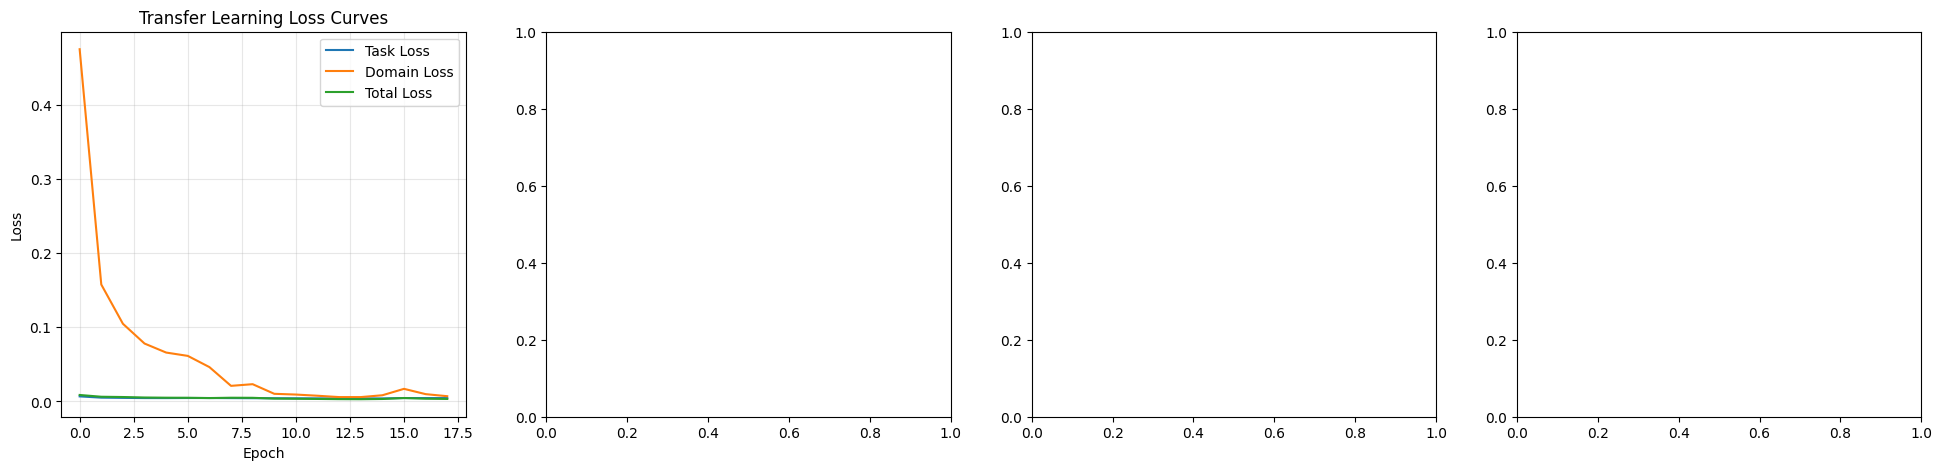

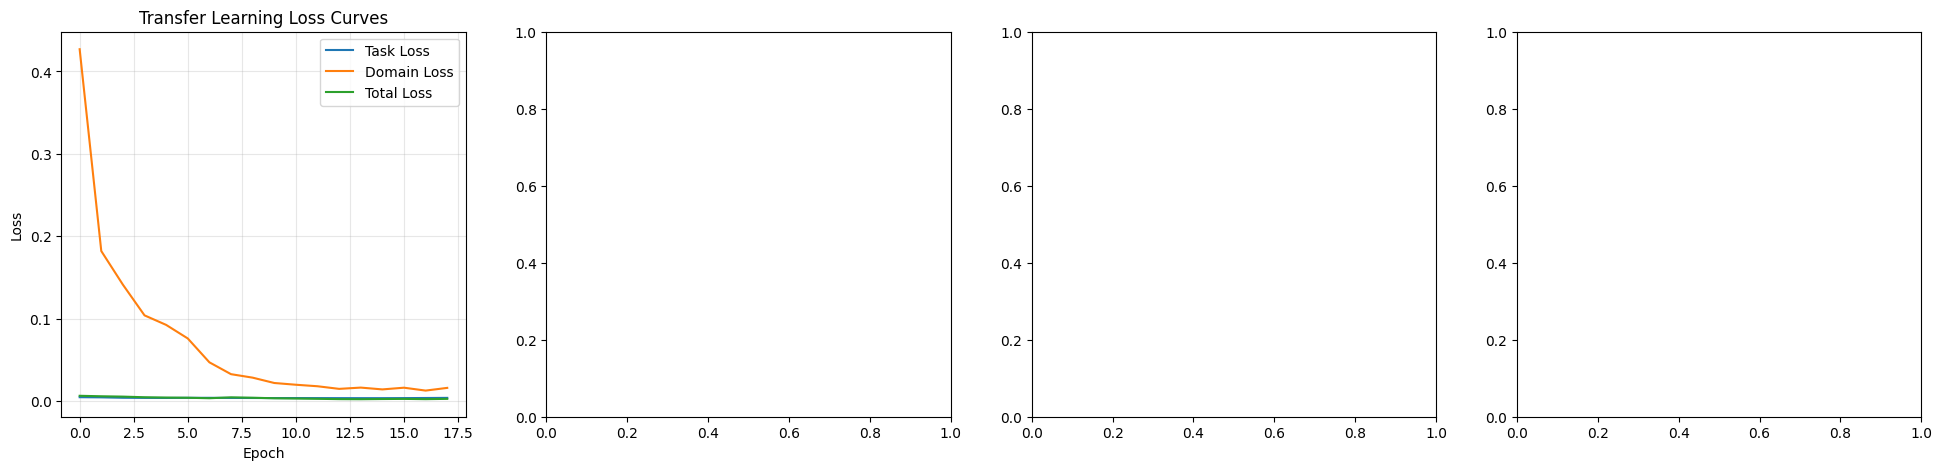

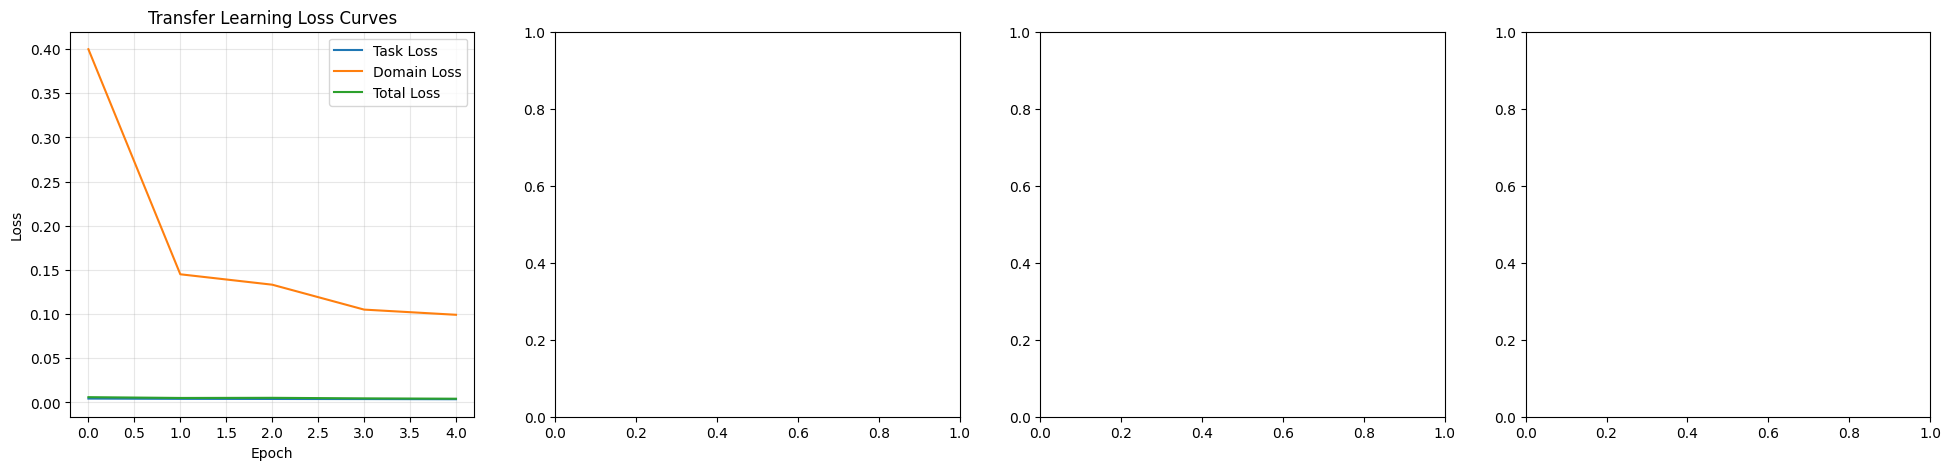

In [9]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import bisect
from bilstm import BaselineBiLSTM

# -------------------------- 模型参数设置 --------------------------
batch_size = 32
sequence_length = 24
forecast_horizon = 24
hidden_dim = 64
num_layers = 2
dropout = 0.3
learning_rate = 0.001
weight_decay = 1e-5
epochs = 12
transfer_epochs = 18
input_dim = 6
num_domains = 6  # 添加域数量参数
# 定义域索引映射（源域=0，目标域依次为1-5）
DOMAIN_MAPPING = {
    "DO": 1,
    "HO": 2,
    "LI": 3,
    "OF": 4,
    "UL": 5,
    "CC": None
}
source_model_path = 'models/adaptive_source_huber_best.pth' 
transfer_results = {}
source_domain_idx = 0  # 源域索引
# 数据缺失场景
data_shortage_scenarios = ['mild', 'heavy', 'extreme']
with open('train_test_labels.json', 'r') as f:
    train_test_labels = json.load(f)
# 加载数据
print("加载所有类别的训练数据...")
train_loader, test_loader, categories = create_all_dataloaders(
    batch_size=batch_size, 
    sequence_length=sequence_length, 
    forecast_horizon=forecast_horizon
)

# 获取数据维度信息
for inputs, targets, category, category_onehot in train_loader:
    print(f"输入形状: {inputs.shape}, 目标形状: {targets.shape}, 类别形状: {category_onehot.shape}")
    input_dim = inputs.shape[-1]
    num_buildings = inputs.shape[1]
    category_dim = category_onehot.shape[-1]
    break

# -------------------------- 加载源域模型 --------------------------
if os.path.exists(source_model_path):
    # 加载完整的模型信息字典
    checkpoint = torch.load(source_model_path)
    
    # 创建模型实例 - 使用贝叶斯域自适应模型
    source_model = AdaptiveBiLSTM(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        category_dim=category_dim,
        forecast_horizon=forecast_horizon,
        num_buildings=1,
        num_domains=num_domains,  # 指定域数量
        num_layers=num_layers,
        dropout=dropout
    )
    
    # 如果是完整的检查点格式，需要提取state_dict
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        source_model.load_state_dict(checkpoint['state_dict'])
        print(f"✅ 从检查点加载自适应源域模型成功: {source_model_path}")
        # 可以打印一些额外信息
        print(f"   模型保存于第 {checkpoint.get('epoch', 'unknown')} 轮")
        print(f"   验证损失: {checkpoint.get('val_loss', 'unknown')}")
    else:
        # 如果只是普通的state_dict
        source_model.load_state_dict(checkpoint)
        print(f"✅ 加载自适应源域模型成功: {source_model_path}")
else:
    print(f"❌ 错误：找不到自适应源域模型 {source_model_path}")
    import sys
    sys.exit(1)

def create_combined_dataloaders(source_category, target_category, data_shortage, batch_size, sequence_length, forecast_horizon):
    """
    构建合并数据加载器（源域：mild，目标域：指定缺失程度）
    对于CC类别，使用所有其他类别的训练数据作为源域
    """
    print(f"为类别 {target_category} 创建数据加载器 (shortage: {data_shortage})...")
    
    try:
        # 正常类别的处理逻辑（非CC类别）
        if train_test_labels[target_category]["train"] is not None:
            # 源域使用完整 mild 数据
            source_train_loader, source_test_loader, _ = create_category_dataloaders(
                category=target_category,
                batch_size=batch_size,
                sequence_length=sequence_length,
                forecast_horizon=forecast_horizon,
                data_shortage='mild'
            )

            # 目标域使用指定数据缺失场景
            target_train_loader, target_test_loader, _ = create_category_dataloaders(
                category=target_category,
                batch_size=batch_size,
                sequence_length=sequence_length,
                forecast_horizon=forecast_horizon,
                data_shortage=data_shortage
            )

            # 检查数据加载器是否为None
            if source_train_loader is None or target_train_loader is None:
                print(f"警告：无法创建 {target_category} 的数据加载器")
                return None, None, None, categories

            class SingleBuildingWrapper(Dataset):
                """确保所有样本都只包含一个建筑的数据集包装器"""
                def __init__(self, dataset):
                    self.dataset = dataset

                def __len__(self):
                    return len(self.dataset)

                def __getitem__(self, idx):
                    # 获取原始样本
                    data = self.dataset[idx]
                    if isinstance(data, tuple) and len(data) >= 2:
                        inputs, targets = data[0], data[1]
                        
                        # 检查并确保只使用一个建筑
                        if inputs.shape[0] > 1:
                            inputs = inputs[0:1]  # 只保留第一个建筑
                            targets = targets[0:1]  # 同样只保留第一个建筑的目标
                        
                        # 重建tuple
                        result = (inputs,) + (targets,) + data[2:]
                        return result
                    else:
                        return data

            # 使用包装器处理每个数据集
            source_train_dataset = SingleBuildingWrapper(source_train_loader.dataset)
            source_test_dataset = SingleBuildingWrapper(source_test_loader.dataset)
            target_train_dataset = SingleBuildingWrapper(target_train_loader.dataset)
            target_test_dataset = SingleBuildingWrapper(target_test_loader.dataset)

            class CombinedDataset(Dataset):
                def __init__(self, datasets):
                    self.datasets = datasets
                    self.lengths = [len(ds) for ds in datasets]
                    self.cumulative_lengths = [0]
                    for length in self.lengths:
                        self.cumulative_lengths.append(self.cumulative_lengths[-1] + length)

                def __len__(self):
                    return sum(self.lengths)

                def __getitem__(self, idx):
                    dataset_idx = bisect.bisect_right(self.cumulative_lengths, idx) - 1
                    sample_idx = idx - self.cumulative_lengths[dataset_idx]
                    return self.datasets[dataset_idx][sample_idx]

            # 合并处理后的数据集
            combined_dataset = CombinedDataset([
                source_train_dataset,
                source_test_dataset,
                target_train_dataset
            ])

            # 创建新的数据加载器
            combined_train_loader = DataLoader(
                combined_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0
            )
            
            # 目标测试集也需要使用单建筑格式
            target_test_loader_single = DataLoader(
                target_test_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0
            )
            
            # 目标训练集也需要使用单建筑格式
            target_train_loader_single = DataLoader(
                target_train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0
            )

            print(f"成功创建 {target_category} 的数据加载器，共 {len(combined_dataset)} 个样本")
            return combined_train_loader, target_test_loader_single, target_train_loader_single, categories
        
        # CC类别的特殊处理
        else:
            print(f"类别 {target_category} 没有训练数据，使用特殊处理")
            
            # 收集所有其他类别的训练数据作为源域
            all_source_datasets = []
            
            for cat in categories:
                if cat != target_category and train_test_labels[cat]["train"] is not None:
                    # 加载其他类别的训练数据（使用mild数据）
                    cat_train_loader, _, _ = create_category_dataloaders(
                        category=cat,
                        batch_size=batch_size,
                        sequence_length=sequence_length,
                        forecast_horizon=forecast_horizon,
                        data_shortage='mild'  # 源域使用完整数据
                    )
                    if cat_train_loader is not None:
                        all_source_datasets.append(cat_train_loader.dataset)
            
            # 获取CC类别的测试数据（作为目标域）
            _, cc_test_loader, _ = create_category_dataloaders(
                category=target_category,
                batch_size=batch_size,
                sequence_length=sequence_length,
                forecast_horizon=forecast_horizon,
                data_shortage=data_shortage
            )
            
            if not all_source_datasets or cc_test_loader is None:
                print(f"警告：无法为CC类别创建数据加载器")
                return None, None, None, categories
            
            # 获取CC测试建筑ID
            cc_test_building = train_test_labels[target_category]["test"][0]
            
            # 创建一个简单的单建筑数据集作为训练集
            class EmptyDataset(Dataset):
                def __len__(self):
                    return 10  # 小数据集
                
                def __getitem__(self, idx):
                    # 创建一个兼容的数据项
                    x = torch.zeros((1, sequence_length, input_dim))  # [1建筑, 序列长度, 特征维度]
                    y = torch.zeros((1, forecast_horizon))  # [1建筑, 预测长度]
                    category = target_category
                    category_onehot = torch.zeros(len(categories))
                    category_idx = categories.index(target_category)
                    category_onehot[category_idx] = 1.0
                    return x, y, category, category_onehot
            
            # 使用包装器确保数据格式一致
            class SingleBuildingWrapper(Dataset):
                def __init__(self, dataset):
                    self.dataset = dataset

                def __len__(self):
                    return len(self.dataset)

                def __getitem__(self, idx):
                    data = self.dataset[idx]
                    if isinstance(data, tuple) and len(data) >= 2:
                        inputs, targets = data[0], data[1]
                        if inputs.shape[0] > 1:
                            inputs = inputs[0:1]
                            targets = targets[0:1]
                        result = (inputs,) + (targets,) + data[2:]
                        return result
                    else:
                        return data
            
            # 包装所有源域数据集
            wrapped_source_datasets = [SingleBuildingWrapper(ds) for ds in all_source_datasets]
            
            # 创建空的训练集作为CC的训练数据
            cc_train_dataset = EmptyDataset()
            wrapped_cc_train = SingleBuildingWrapper(cc_train_dataset)
            wrapped_cc_test = SingleBuildingWrapper(cc_test_loader.dataset)
            
            # 合并所有源域数据和CC的训练数据
            class CombinedDataset(Dataset):
                def __init__(self, datasets):
                    self.datasets = datasets
                    self.lengths = [len(ds) for ds in datasets]
                    self.cumulative_lengths = [0]
                    for length in self.lengths:
                        self.cumulative_lengths.append(self.cumulative_lengths[-1] + length)

                def __len__(self):
                    return sum(self.lengths)

                def __getitem__(self, idx):
                    dataset_idx = bisect.bisect_right(self.cumulative_lengths, idx) - 1
                    sample_idx = idx - self.cumulative_lengths[dataset_idx]
                    return self.datasets[dataset_idx][sample_idx]
            
            # combined_train_loader = 所有其他类别的训练数据 + CC的训练时间段数据
            combined_dataset = CombinedDataset(wrapped_source_datasets + [wrapped_cc_train])
            combined_train_loader = DataLoader(
                combined_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0
            )
            
            # target_test_loader_single = CC的测试数据
            target_test_loader_single = DataLoader(
                wrapped_cc_test,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0
            )
            
            # target_train_loader_single = CC的训练时间段数据
            target_train_loader_single = DataLoader(
                wrapped_cc_train,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0
            )
            
            print(f"CC类别数据加载器创建成功:")
            print(f"  - combined_train_loader: {len(combined_dataset)} 样本 (包含所有其他类别 + CC训练时间段)")
            print(f"  - target_test_loader: {len(wrapped_cc_test)} 样本")
            print(f"  - target_train_loader: {len(wrapped_cc_train)} 样本")
            
            return combined_train_loader, target_test_loader_single, target_train_loader_single, categories
    
    except Exception as e:
        print(f"创建数据加载器时出错: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, categories

# -------------------------- 创建基线Huber损失模型 --------------------------
class HuberBaselineBiLSTM(BaselineBiLSTM):
    """
    支持直接输出的基线BiLSTM模型，使用Huber损失训练
    """
    def __init__(self, input_dim, hidden_dim, forecast_horizon, num_buildings=1, num_layers=2, dropout=0.3):
        super().__init__(input_dim, hidden_dim, forecast_horizon, num_buildings, num_layers, dropout)
        
        # 使用单一输出层进行直接预测 - 注意这里使用 hidden_dim * 2 来匹配双向LSTM的输出
        self.fc = torch.nn.Linear(hidden_dim * 2, forecast_horizon)
        
    def forward(self, x, category_onehot=None):  # 修改这里，保持与父类一致的参数
        # x形状: [batch, num_buildings, seq_len, input_dim]
        batch_size, num_buildings, seq_len, _ = x.shape
        
        # 重塑为[batch*num_buildings, seq_len, input_dim]
        x = x.reshape(batch_size * num_buildings, seq_len, -1)
        
        # LSTM层处理
        lstm_out, _ = self.lstm(x)
        
        # 只取最后一个时间步的输出
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        
        # 直接输出预测值
        predictions = self.fc(out)
        
        # 重塑回[batch, num_buildings, forecast_horizon]
        predictions = predictions.view(batch_size, num_buildings, -1)
        
        return predictions

        
def train_huber_model(model, train_loader, val_loader, epochs=20, lr=0.001, weight_decay=1e-5):
    """训练使用Huber损失的模型"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # 定义Huber损失函数
    huber_loss_fn = HuberLoss(delta=1.0)
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0
        for i, (inputs, targets, *extra) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = huber_loss_fn(predictions, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        train_loss = epoch_loss / len(train_loader)
        history["train_loss"].append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets, *extra in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                predictions = model(inputs)
                loss = huber_loss_fn(predictions, targets)
                val_loss += loss.item()
                
        val_loss = val_loss / len(val_loader)
        history["val_loss"].append(val_loss)
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # 早停
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # 恢复最佳模型
    if best_model_state:
        model.load_state_dict(best_model_state)
        
    return model, history, best_val_loss

import traceback
import logging
from datetime import datetime, UTC



# 在迁移学习循环之前设置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('transfer_learning.log'),
        logging.StreamHandler()
    ]
)

# -------------------------- 主迁移学习循环 --------------------------
# -------------------------- 主迁移学习循环 --------------------------
current_user = "leime2ijuan"
source_model_category = 'ALL'
current_time = datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%S")
logging.info(f"Starting transfer learning experiment")
logging.info(f"Time: {current_time}")
logging.info(f"User: {current_user}")
checkpoint_path = os.path.join('checkpoints', f'transfer_checkpoint_{target_domain_idx}.pth')
for target_category in categories:
    print(f"当前处理类别: {target_category}")

        
    transfer_results[target_category] = {}
    # 获取当前目标类别的域索引
    target_domain_idx = DOMAIN_MAPPING[target_category]
    for data_shortage in data_shortage_scenarios:
        logging.info(f"\n🚀 [Transfer Learning] Source({source_model_category}) ➜ Target({target_category}), Shortage: {data_shortage}")

        try:
            # 加载数据
            combined_train_loader, target_test_loader, target_train_loader, _ = create_combined_dataloaders(
                source_category=target_category,
                target_category=target_category,
                data_shortage=data_shortage,
                batch_size=batch_size,
                sequence_length=sequence_length,
                forecast_horizon=forecast_horizon
            )

            # Baseline模型训练
            logging.info(f"📦 Training Huber baseline model for category {target_category}...")
            baseline_model = HuberBaselineBiLSTM(
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                forecast_horizon=forecast_horizon,
                num_buildings=1,
                num_layers=num_layers,
                dropout=dropout
            ).to(device)

            trained_baseline_model, base_history, _ = train_huber_model(
                model=baseline_model,
                train_loader=target_train_loader,
                val_loader=target_test_loader,
                epochs=transfer_epochs // 2,
                lr=learning_rate,
                weight_decay=weight_decay
            )

            # 迁移学习过程
            adapted_model, transfer_history = adapt_to_target_domain(
                source_model=source_model,
                source_loader=combined_train_loader,
                target_loader=target_test_loader,
                epochs=transfer_epochs,
                lr=learning_rate / 2,
                device=device,
                lambda_domain=0.4,
                early_stopping_patience=3,
                source_domain_idx=source_domain_idx,
                target_domain_idx=target_domain_idx
            )

            # 评估模型性能
            metrics = evaluate_model(
                model=adapted_model,
                test_loader=target_test_loader,
                model_name=f"Adaptive_TL_ALL_to_{target_category}_{data_shortage}",
                baseline_model=trained_baseline_model,
                device=device,
                domain_idx=target_domain_idx
            )

            # 保存结果 - 包括迁移学习评估结果
            is_adaptive_model = hasattr(adapted_model, 'time_series_encoder')
            model_type = "adaptive" if is_adaptive_model else "chronos"
            
            # 提取基线模型指标（包含不确定性）
            baseline_metrics = metrics.get('baseline_metrics', {})
            
            # 保存迁移学习结果（修改部分）
            transfer_results[target_category][data_shortage] = {
                'metrics': metrics,
                'is_adaptive_model': is_adaptive_model,
                'model_type': model_type,
                'transfer_metrics': {
                    'a_distance': metrics.get('a_distance'),
                    'feature_alignment': metrics.get('feature_alignment'),
                    'mmd': metrics.get('mmd'),
                    'is_negative_transfer': metrics.get('is_negative_transfer'),
                    'transfer_gain': metrics.get('transfer_gain'),
                    'sample_efficiency': metrics.get('sample_efficiency'),
                    'baseline_a_distance': metrics.get('baseline_a_distance'),
                    'baseline_feature_alignment': metrics.get('baseline_feature_alignment'),
                    'baseline_mmd': metrics.get('baseline_mmd'),
                    'a_distance_improvement': metrics.get('a_distance_improvement'),
                    'mmd_improvement': metrics.get('mmd_improvement'),
                    'alignment_improvement': metrics.get('alignment_improvement')
                },
                'evaluation_metrics': {
                    'RMSD': metrics.get('RMSD'),
                    'MAPE': metrics.get('MAPE'),
                    'R2': metrics.get('R2'),
                    'CV-RMSE': metrics.get('CV-RMSE'),
                    'SD_real': metrics.get('SD_real'),
                    'SD_pred': metrics.get('SD_pred'),
                    'CC': metrics.get('CC'),
                    'PIR': metrics.get('PIR'),
                    # 新增：主模型不确定性指标
                    'PICP': metrics.get('PICP'),
                    'NMPIW': metrics.get('NMPIW'),
                    'calibration_error': metrics.get('calibration_error'),
                    'UQS': metrics.get('UQS'),
                    'avg_uncertainty': metrics.get('avg_uncertainty')
                },
                'baseline_metrics': {
                    'RMSD': baseline_metrics.get('RMSD', 'N/A'),
                    'MAPE': baseline_metrics.get('MAPE', 'N/A'),
                    'R2': baseline_metrics.get('R2', 'N/A'),
                    'CV-RMSE': baseline_metrics.get('CV-RMSE', 'N/A'),
                    'SD_real': baseline_metrics.get('SD_real', 'N/A'),
                    'SD_pred': baseline_metrics.get('SD_pred', 'N/A'),
                    'CC': baseline_metrics.get('CC', 'N/A'),
                    'PIR': 'N/A',  # 基线无PIR
                    # 新增：基线模型不确定性指标
                    'PICP': baseline_metrics.get('PICP', 'N/A'),
                    'NMPIW': baseline_metrics.get('NMPIW', 'N/A'),
                    'calibration_error': baseline_metrics.get('calibration_error', 'N/A'),
                    'avg_uncertainty': baseline_metrics.get('avg_uncertainty', 'N/A'),
                    'transfer_metrics': {
                        'a_distance': metrics.get('baseline_a_distance', 'N/A'),
                        'feature_alignment': metrics.get('baseline_feature_alignment', 'N/A'),
                        'mmd': metrics.get('baseline_mmd', 'N/A')
                    }
                }
            }

            # 保存模型信息（修改部分）
            model_info = {
                'state_dict': adapted_model.state_dict(),
                'metrics': metrics,
                'history': transfer_history,
                'source_model': source_model_category,
                'target_category': target_category,
                'data_shortage': data_shortage,
                'model_config': {
                    'input_dim': input_dim,
                    'hidden_dim': hidden_dim,
                    'forecast_horizon': forecast_horizon,
                    'category_dim': category_dim,
                    'num_layers': num_layers,
                    'dropout': dropout,
                },
                'transfer_evaluation': {
                    'a_distance': metrics.get('a_distance', 'N/A'),
                    'feature_alignment': metrics.get('feature_alignment', 'N/A'),
                    'mmd': metrics.get('mmd', 'N/A'),
                    'is_negative_transfer': metrics.get('is_negative_transfer', 'N/A'),
                    'transfer_gain': metrics.get('transfer_gain', 'N/A'),
                    'sample_efficiency': metrics.get('sample_efficiency', 'N/A'),
                    'a_distance_improvement': metrics.get('a_distance_improvement', 'N/A'),
                    'mmd_improvement': metrics.get('mmd_improvement', 'N/A'),
                    'alignment_improvement': metrics.get('alignment_improvement', 'N/A')
                },
                'detailed_metrics': {
                    'RMSD': metrics.get('RMSD', 'N/A'),
                    'MAPE': metrics.get('MAPE', 'N/A'),
                    'R2': metrics.get('R2', 'N/A'),
                    'CV-RMSE': metrics.get('CV-RMSE', 'N/A'),
                    'SD_real': metrics.get('SD_real', 'N/A'),
                    'SD_pred': metrics.get('SD_pred', 'N/A'),
                    'CC': metrics.get('CC', 'N/A'),
                    'PIR': metrics.get('PIR', 'N/A'),
                    'PICP': metrics.get('PICP', 'N/A'),
                    'NMPIW': metrics.get('NMPIW', 'N/A'),
                    'calibration_error': metrics.get('calibration_error', 'N/A'),
                    'UQS': metrics.get('UQS', 'N/A'),
                    'avg_uncertainty': metrics.get('avg_uncertainty', 'N/A')
                },
                'baseline_metrics': {
                    'RMSD': baseline_metrics.get('RMSD', 'N/A'),
                    'MAPE': baseline_metrics.get('MAPE', 'N/A'),
                    'R2': baseline_metrics.get('R2', 'N/A'),
                    'CV-RMSE': baseline_metrics.get('CV-RMSE', 'N/A'),
                    'SD_real': baseline_metrics.get('SD_real', 'N/A'),
                    'SD_pred': baseline_metrics.get('SD_pred', 'N/A'),
                    'CC': baseline_metrics.get('CC', 'N/A'),
                    'PIR': 'N/A',  # 基线无PIR
                    'PICP': baseline_metrics.get('PICP', 'N/A'),
                    'NMPIW': baseline_metrics.get('NMPIW', 'N/A'),
                    'calibration_error': baseline_metrics.get('calibration_error', 'N/A'),
                    'avg_uncertainty': baseline_metrics.get('avg_uncertainty', 'N/A'),
                    'transfer_metrics': {
                        'a_distance': metrics.get('baseline_a_distance', 'N/A'),
                        'feature_alignment': metrics.get('baseline_feature_alignment', 'N/A'),
                        'mmd': metrics.get('baseline_mmd', 'N/A')
                    }
                }
            }
            
            # 保存模型
            torch.save(model_info, 
                f'models/{model_type}_TL_ALL_to_{target_category}_{data_shortage}.pth')

            # 打印迁移学习指标
            print("\nTransfer Learning Metrics:")
            a_distance = metrics.get('a_distance', 'N/A')
            print(f"A-distance: {a_distance:.4f}" if isinstance(a_distance, (int, float)) else f"A-distance: {a_distance}")
            
            feature_alignment = metrics.get('feature_alignment', 'N/A')
            print(f"Feature Alignment: {feature_alignment:.4f}" if isinstance(feature_alignment, (int, float)) else f"Feature Alignment: {feature_alignment}")
            
            mmd = metrics.get('mmd', 'N/A')
            print(f"MMD: {mmd:.4f}" if isinstance(mmd, (int, float)) else f"MMD: {mmd}")
            
            if metrics.get('is_negative_transfer') is not None:
                print(f"Negative Transfer: {'Yes' if metrics['is_negative_transfer'] else 'No'}")
                transfer_gain = metrics.get('transfer_gain', 'N/A')
                print(f"Transfer Gain: {transfer_gain:.4f}" if isinstance(transfer_gain, (int, float)) else f"Transfer Gain: {transfer_gain}")
            
            if metrics.get('sample_efficiency') is not None:
                print(f"Sample Efficiency: {metrics['sample_efficiency']}")

            # 打印基线模型与迁移模型的对比（修改部分）
            if baseline_metrics:
                print("\nBaseline vs. Transfer Model Comparison:")
                
                # 基本评估指标对比
                baseline_rmse = baseline_metrics.get('RMSD', 'N/A')
                transfer_rmse = metrics.get('RMSD', 'N/A')
                print(f"RMSD: Baseline={baseline_rmse:.4f}" if isinstance(baseline_rmse, (int, float)) else f"RMSD: Baseline={baseline_rmse}",
                      f"vs. Transfer={transfer_rmse:.4f}" if isinstance(transfer_rmse, (int, float)) else f"vs. Transfer={transfer_rmse}")
                
                baseline_cv_rmse = baseline_metrics.get('CV-RMSE', 'N/A')
                transfer_cv_rmse = metrics.get('CV-RMSE', 'N/A')
                if isinstance(baseline_cv_rmse, (int, float)) or isinstance(transfer_cv_rmse, (int, float)):
                    print(f"CV-RMSE: Baseline={baseline_cv_rmse:.4f}%" if isinstance(baseline_cv_rmse, (int, float)) else f"CV-RMSE: Baseline={baseline_cv_rmse}%",
                          f"vs. Transfer={transfer_cv_rmse:.4f}%" if isinstance(transfer_cv_rmse, (int, float)) else f"vs. Transfer={transfer_cv_rmse}%")
                
                baseline_cc = baseline_metrics.get('CC', 'N/A')
                transfer_cc = metrics.get('CC', 'N/A')
                if isinstance(baseline_cc, (int, float)) or isinstance(transfer_cc, (int, float)):
                    print(f"CC: Baseline={baseline_cc:.4f}" if isinstance(baseline_cc, (int, float)) else f"CC: Baseline={baseline_cc}",
                          f"vs. Transfer={transfer_cc:.4f}" if isinstance(transfer_cc, (int, float)) else f"vs. Transfer={transfer_cc}")
                
                baseline_r2 = baseline_metrics.get('R2', 'N/A')
                transfer_r2 = metrics.get('R2', 'N/A')
                if isinstance(baseline_r2, (int, float)) or isinstance(transfer_r2, (int, float)):
                    print(f"R²: Baseline={baseline_r2:.4f}" if isinstance(baseline_r2, (int, float)) else f"R²: Baseline={baseline_r2}",
                          f"vs. Transfer={transfer_r2:.4f}" if isinstance(transfer_r2, (int, float)) else f"vs. Transfer={transfer_r2}")
                
                # 新增：不确定性指标对比
                print("\n不确定性指标对比:")
                baseline_picp = baseline_metrics.get('PICP', 'N/A')
                transfer_picp = metrics.get('PICP', 'N/A')
                print(f"PICP: Baseline={baseline_picp:.2f}%" if isinstance(baseline_picp, (int, float)) else f"PICP: Baseline={baseline_picp}%",
                      f"vs. Transfer={transfer_picp:.2f}%" if isinstance(transfer_picp, (int, float)) else f"vs. Transfer={transfer_picp}%")
                
                baseline_nmpiw = baseline_metrics.get('NMPIW', 'N/A')
                transfer_nmpiw = metrics.get('NMPIW', 'N/A')
                print(f"NMPIW: Baseline={baseline_nmpiw:.4f}" if isinstance(baseline_nmpiw, (int, float)) else f"NMPIW: Baseline={baseline_nmpiw}",
                      f"vs. Transfer={transfer_nmpiw:.4f}" if isinstance(transfer_nmpiw, (int, float)) else f"vs. Transfer={transfer_nmpiw}")
                
                baseline_cal_err = baseline_metrics.get('calibration_error', 'N/A')
                transfer_cal_err = metrics.get('calibration_error', 'N/A')
                print(f"校准误差: Baseline={baseline_cal_err:.2f}%" if isinstance(baseline_cal_err, (int, float)) else f"校准误差: Baseline={baseline_cal_err}%",
                      f"vs. Transfer={transfer_cal_err:.2f}%" if isinstance(transfer_cal_err, (int, float)) else f"vs. Transfer={transfer_cal_err}%")
                
                baseline_uncertainty = baseline_metrics.get('avg_uncertainty', 'N/A')
                transfer_uncertainty = metrics.get('avg_uncertainty', 'N/A')
                print(f"平均不确定性: Baseline={baseline_uncertainty:.4f}" if isinstance(baseline_uncertainty, (int, float)) else f"平均不确定性: Baseline={baseline_uncertainty}",
                      f"vs. Transfer={transfer_uncertainty:.4f}" if isinstance(transfer_uncertainty, (int, float)) else f"vs. Transfer={transfer_uncertainty}")
                
                # 迁移指标对比（仅当基线模型有迁移指标时显示）
                if metrics.get('baseline_a_distance') is not None or metrics.get('a_distance') is not None:
                    print("\nDomain Adaptation Comparison:")
                    baseline_a_distance = metrics.get('baseline_a_distance', 'N/A')
                    print(f"A-distance: Baseline={baseline_a_distance:.4f}" if isinstance(baseline_a_distance, (int, float)) else f"A-distance: Baseline={baseline_a_distance}",
                          f"vs. Transfer={a_distance:.4f}" if isinstance(a_distance, (int, float)) else f"vs. Transfer={a_distance}")
                
                if metrics.get('baseline_feature_alignment') is not None or metrics.get('feature_alignment') is not None:
                    baseline_feature_alignment = metrics.get('baseline_feature_alignment', 'N/A')
                    print(f"Feature Alignment: Baseline={baseline_feature_alignment:.4f}" if isinstance(baseline_feature_alignment, (int, float)) else f"Feature Alignment: Baseline={baseline_feature_alignment}",
                          f"vs. Transfer={feature_alignment:.4f}" if isinstance(feature_alignment, (int, float)) else f"vs. Transfer={feature_alignment}")
                
                if metrics.get('baseline_mmd') is not None or metrics.get('mmd') is not None:
                    baseline_mmd = metrics.get('baseline_mmd', 'N/A')
                    print(f"MMD: Baseline={baseline_mmd:.4f}" if isinstance(baseline_mmd, (int, float)) else f"MMD: Baseline={baseline_mmd}",
                          f"vs. Transfer={mmd:.4f}" if isinstance(mmd, (int, float)) else f"vs. Transfer={mmd}")

            # 绘制训练曲线（原有逻辑不变）
            fig, axes = plt.subplots(1, 4, figsize=(24, 5))
            
            # 损失曲线
            axes[0].plot(transfer_history['task_loss'], label='Task Loss')
            axes[0].plot(transfer_history['domain_loss'], label='Domain Loss')
            axes[0].plot(transfer_history['total_loss'], label='Total Loss')
            axes[0].set_title('Transfer Learning Loss Curves')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # MMD和特征对齐度曲线
            if 'mmd_history' in transfer_history:
                axes[1].plot(transfer_history['mmd_history'], label='MMD')
                axes[1].plot(transfer_history['feature_alignment_history'], label='Feature Alignment')
                axes[1].set_title('Domain Adaptation Metrics')
                axes[1].set_xlabel('Epoch')
                axes[1].set_ylabel('Value')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
            
            # 评估指标曲线
            if 'metrics_history' in transfer_history:
                metrics_history = transfer_history['metrics_history']
                if 'RMSD' in metrics_history:
                    axes[2].plot(metrics_history['RMSD'], label='RMSD')
                if 'CV-RMSE' in metrics_history:
                    axes[2].plot(metrics_history['CV-RMSE'], label='CV-RMSE')
                if 'CC' in metrics_history:
                    axes[2].plot(metrics_history['CC'], label='CC')
                axes[2].set_title('Evaluation Metrics')
                axes[2].set_xlabel('Epoch')
                axes[2].set_ylabel('Value')
                axes[2].legend()
                axes[2].grid(True, alpha=0.3)
            
            # 模型性能对比图
            if baseline_metrics:
                fig, axes = plt.subplots(1, 2, figsize=(18, 6))
                
                # 基本评估指标对比
                metrics_to_compare = ['RMSD', 'CV-RMSE', 'CC', 'R2']
                transfer_values = [metrics.get(m, 'N/A') for m in metrics_to_compare]
                baseline_values = [baseline_metrics.get(m, 'N/A') for m in metrics_to_compare]
                
                x = np.arange(len(metrics_to_compare))
                width = 0.35
                transfer_numeric = [float(v) if isinstance(v, (int, float)) else np.nan for v in transfer_values]
                baseline_numeric = [float(v) if isinstance(v, (int, float)) else np.nan for v in baseline_values]
                
                axes[0].bar(x - width/2, transfer_numeric, width, label='Transfer Model')
                axes[0].bar(x + width/2, baseline_numeric, width, label='Baseline Model')
                axes[0].set_title('Model Performance Comparison')
                axes[0].set_xlabel('Metrics')
                axes[0].set_ylabel('Value')
                axes[0].set_xticks(x)
                axes[0].set_xticklabels(['RMSD', 'CV-RMSE (%)', 'CC', 'R²'])
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # 迁移指标对比
                transfer_metrics_to_compare = ['a_distance', 'feature_alignment', 'mmd']
                transfer_transfer_values = [metrics.get(m, 'N/A') for m in transfer_metrics_to_compare]
                baseline_transfer_values = [metrics.get(f'baseline_{m}', 'N/A') for m in transfer_metrics_to_compare]
                
                x_t = np.arange(len(transfer_metrics_to_compare))
                transfer_t_numeric = [float(v) if isinstance(v, (int, float)) else np.nan for v in transfer_transfer_values]
                baseline_t_numeric = [float(v) if isinstance(v, (int, float)) else np.nan for v in baseline_transfer_values]
                
                axes[1].bar(x_t - width/2, transfer_t_numeric, width, label='Transfer Model')
                axes[1].bar(x_t + width/2, baseline_t_numeric, width, label='Baseline Model')
                axes[1].set_title('Domain Adaptation Comparison')
                axes[1].set_xlabel('Metrics')
                axes[1].set_ylabel('Value')
                axes[1].set_xticks(x_t)
                axes[1].set_xticklabels(['A-distance', 'Feature Alignment', 'MMD'])
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(f'models/{model_type}_TL_comparison_{target_category}_{data_shortage}.png')
                plt.close()

        except Exception as e:
            print(f"❌ Error: {target_category}/{data_shortage} transfer failed: {e}")
            traceback.print_exc()
            continue

print("\n✅ All transfer learning experiments completed")
print("\n📊 Generating additional visualization charts...")

In [10]:
# -------------------------- 新增：保存结果到CSV --------------------------
import csv
from datetime import datetime
import numpy as np
import torch

def convert_to_basic_type(obj):
    """将对象转换为基本数据类型，以便保存到CSV"""
    if obj is None:
        return "None"
    elif isinstance(obj, (np.ndarray, torch.Tensor)):
        # 处理数组和张量
        if obj.size == 1:
            try:
                return float(obj.item()) if np.issubdtype(obj.dtype, np.floating) else int(obj.item())
            except:
                return float(obj) if np.issubdtype(type(obj), np.floating) else int(obj)
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        # 处理NumPy标量
        return float(obj) if np.issubdtype(obj.dtype, np.floating) else int(obj)
    elif isinstance(obj, (float, int, str, bool)):
        # 基本类型直接返回
        return obj
    else:
        # 其他类型转换为字符串
        return str(obj)

# 定义CSV文件路径
csv_path = "transfer_results_CC.csv"

# 准备CSV表头（简化版，按模型类型分类）
csv_header = [
    "Target Category", "Data Shortage", "Model Type", 
    "RMSD", "MAPE (%)", "R2", "CV-RMSE (%)", "SD_real", "SD_pred", "CC", 
    "PIR (%)", "PICP (%)", "NMPIW", "Calibration Error (%)", "UQS", "Avg Uncertainty",
    "A-distance", "Feature Alignment", "MMD", "Negative Transfer", "Transfer Gain", "Sample Efficiency",
    "Baseline A-distance", "Baseline Feature Alignment", "Baseline MMD"
]

# 准备数据行
csv_rows = []

# 遍历所有实验结果
for target_category in transfer_results:
    for data_shortage in transfer_results[target_category]:
        result = transfer_results[target_category][data_shortage]
        
        # 处理基线模型
        baseline_metrics = result.get('baseline_metrics', {})
        if baseline_metrics:
            # 获取基线模型的迁移指标
            baseline_transfer_metrics = baseline_metrics.get('transfer_metrics', {})
            
            row = [
                target_category, data_shortage, "Baseline",
                convert_to_basic_type(baseline_metrics.get('RMSD', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('MAPE', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('R2', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('CV-RMSE', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('SD_real', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('SD_pred', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('CC', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('PIR', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('PICP', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('NMPIW', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('calibration_error', 'N/A')),
                convert_to_basic_type(baseline_metrics.get('UQS', 'N/A')),  # 可能不存在，返回N/A
                convert_to_basic_type(baseline_metrics.get('avg_uncertainty', 'N/A')),
                "N/A", "N/A", "N/A", "N/A", "N/A", "N/A",  # 迁移模型特有指标
                # 基线模型的迁移指标
                convert_to_basic_type(baseline_transfer_metrics.get('a_distance', 'N/A')),
                convert_to_basic_type(baseline_transfer_metrics.get('feature_alignment', 'N/A')),
                convert_to_basic_type(baseline_transfer_metrics.get('mmd', 'N/A'))
            ]
            csv_rows.append(row)
        
        # 处理迁移模型
        model_metrics = result.get('metrics', {})
        transfer_metrics = result.get('transfer_metrics', {})
        if model_metrics:
            row = [
                target_category, data_shortage, result.get('model_type', 'Transfer'),
                convert_to_basic_type(model_metrics.get('RMSD', 'N/A')),
                convert_to_basic_type(model_metrics.get('MAPE', 'N/A')),
                convert_to_basic_type(model_metrics.get('R2', 'N/A')),
                convert_to_basic_type(model_metrics.get('CV-RMSE', 'N/A')),
                convert_to_basic_type(model_metrics.get('SD_real', 'N/A')),
                convert_to_basic_type(model_metrics.get('SD_pred', 'N/A')),
                convert_to_basic_type(model_metrics.get('CC', 'N/A')),
                convert_to_basic_type(model_metrics.get('PIR', 'N/A')),
                convert_to_basic_type(model_metrics.get('PICP', 'N/A')),
                convert_to_basic_type(model_metrics.get('NMPIW', 'N/A')),
                convert_to_basic_type(model_metrics.get('calibration_error', 'N/A')),
                convert_to_basic_type(model_metrics.get('UQS', 'N/A')),
                convert_to_basic_type(model_metrics.get('avg_uncertainty', 'N/A')),
                # 迁移指标
                convert_to_basic_type(transfer_metrics.get('a_distance', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('feature_alignment', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('mmd', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('is_negative_transfer', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('transfer_gain', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('sample_efficiency', 'N/A')),
                # 迁移模型的基线指标（重复列，用于对比）
                convert_to_basic_type(transfer_metrics.get('baseline_a_distance', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('baseline_feature_alignment', 'N/A')),
                convert_to_basic_type(transfer_metrics.get('baseline_mmd', 'N/A'))
            ]
            csv_rows.append(row)

# 写入CSV文件
with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_header)
    writer.writerows(csv_rows)

print(f"\n💾 迁移学习结果已保存至 {csv_path}")
print("\n📊 Generating additional visualization charts...")


💾 迁移学习结果已保存至 transfer_results_CC.csv

📊 Generating additional visualization charts...
